# Final Project, MHPC 2019-2020

In [1]:
# import modules used in the rest of the notebook
%pylab inline
import sympy as sym
import scipy
from scipy.interpolate import *
from scipy.integrate import *
#rc('font', **{'family':'sans-serif', 'sans-serif':['Helvetica']})
#rc('text', usetext=True)

Populating the interactive namespace from numpy and matplotlib


##  Problem description, and preliminary analysis

The objective is to find a numerical solution via finite difference (in time) to the Allen-Cahn equation 

$$
\partial_{t} \eta - \varepsilon^{2}\partial_{xx} \eta + f'(\eta) = 0,
$$

with boundary conditions

$$
\qquad \partial_{x}\eta(0, t) = \partial_{x}\eta(1, t) = 0,
$$

given an initial condition

$$
\qquad\eta(x,0) = \eta_0(x),
$$

on the domain $\Omega=[0,1]$ for a time interval $[0,T]$.

In particular, we consider the double well potential defined by 

$$
f(\eta) = \eta^{2}(\eta-1)^{2}.
$$

NOTICE: here $f'(\eta)$ is the derivative of the double well potential considered as a one variable function in $\eta$.

In [2]:
n = 1025 # number of sample points for evaluation
x = linspace(0,1, n) # equispaced points in interval for evaluation

In [3]:
'''

f : lambda function computing the double well potential at a point.

'''

f = lambda y : y**2 * (y-1.)**2 

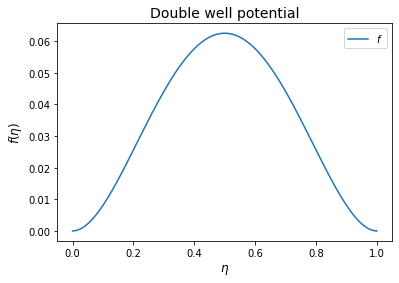

In [4]:
title(r'Double well potential',fontsize=14)
plot(x, f(x), label=r'$f$')
xlabel(r'$\eta$',fontsize=12)
ylabel(r'$f(\eta)$', fontsize=12)
legend()

Given this double well potential and fixed initial conditions, one expects for large values of time a partition of the domain $\Omega$ in three regions:

$$
\Omega_{ \ -} = \{x: \eta_{0}(x)<0.5\}, \ \ \Omega_{\ +} = \{x: \eta_{0}(x)>0.5\}, \ \ 
\Omega_{\ 0} = \{x: \eta_{0}(x)=0.5\}.
$$

On the sub-domain $\Omega_{ \ -}$ the phase is attracted to $0$ in the limit $T\to\infty$, on the sub-domain $\Omega_{ \ +}$ the phase is attracted to $1$, while on the sub-domain $\Omega_{0}$ the phase has a point of equilibrium. 

Thus, for a given initial condition $\eta_{0}$ the limit solution $\eta_{\infty}$ can be predicted applying the following modification of the sign function to $\eta_{0}$:

In [5]:
'''

lim_sol: lambda function computing expected infinite time solution at a point,
for given function init_cond defining initial conditions.

'''

lim_sol = lambda x, init_cond: 0.5 * sign(init_cond(x)-0.5) + 0.5

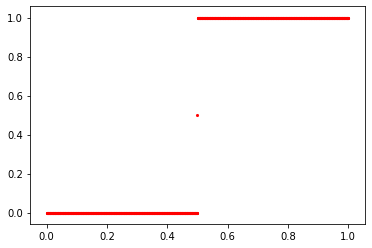

In [6]:
_id = lambda x: x
_ = scatter(x,lim_sol(x,_id), marker='.', linewidths=0.1, color='r')

As an example, consider the choice of $\eta_{0}$ suggested in the exam paper:

$$
\eta_{0}(x)=\sin(2 \pi x)+1.
$$

The expected limit solution has two jump discontinuites on $[0,1]$ at $\eta_{0}=0$.

**Remark:** due to the limitations of our choice of linespace the following plot does NOT represent the two fixed points $(x_{i},0.5)$ for $i\in\{0,1\}$, where $x_{0},x_{1}$ are the solutions of $\eta_{0}=0$, and that will appear in the approximate solution later on in the notebook.

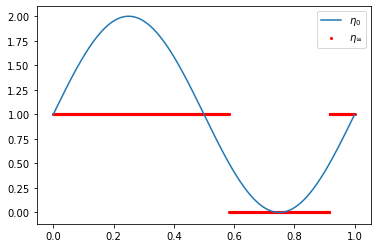

In [7]:
'''
eta_zero : lambda function computing suggested initial condition of our problem at a point.
'''
eta_zero = lambda x: sin( 2 * pi * x ) + 1
_ = plot(x, eta_zero(x), label=r'$\eta_{0}$')
_ = scatter(x,lim_sol(x,eta_zero), marker='.', linewidths=0.1, color='r', label=r'$\eta_{\infty}$')
_ =legend()

Coming back to our task of approximating a solution for a finite time range, the first step towards a discretisation of the problem is a finite difference discretisation in time. Once partitioned the interval $[0,T]$ in intervals of size $\Delta t$ following the forward Euler method we would be left with the eqution:

$$
\eta_{t+1} = \eta_{t} + \varepsilon^{2}\Delta t\partial_{xx} \eta_{t} - \Delta t f'(\eta_{t}).
$$

The method is unstable. One can follow two possible approaches to enure stability.

**First approach.**

Leave the $\Delta t f'(\eta_{t})$ term explicit but modify $\Delta t\varepsilon^{2}\partial_{xx} \eta_{t}$ to become an explicit factor, replacing $\eta_{t}$ with $\eta_{t+1}$. In this way one obtains the equation:

$$
\eta_{t+1} - \varepsilon^{2}\Delta t\partial_{xx}\eta_{t+1} = \eta_{t} - \Delta t f'(\eta_{t}).
$$

This can be translated in the variational form as follows: let $\{v_{i}\}_{I}$ be a basis of the vector space $V\subset H^{1}[0,1]$ where our approximate solutions lie, so that we can write $\eta_{\tau} = \eta^{j}_{\tau}v_{j}$ for any time $\tau$ in our time discretisation, then  

$$
(v_{i},v_{j})\eta^{j}_{t+1} - \varepsilon^{2}\Delta t(v'_{i},v'_{j})\eta^{j}_{t+1} = (v_{i},v_{j})\eta^{j}_{t} - \Delta t (v_{i},f'(\eta_{t})),
$$

where the term $(v'_{i},v'_{j})$ appears from integration by parts and from the boundary conditions. If we assume futher that $\{v_{i}\}_{I}$ is an interpolatory spline basis, we have $(v_{i},f'(\eta_{t}))=(v_{i},v_{j})f'(\eta^{j}_{t})$, so that our approximate solution can be found by recursively $T/(\Delta$ t) linear systems

$$
(M+\varepsilon^{2}\Delta t K) \left(\underline{\eta}_{ \ t+1}\right) = M \left(\underline{\eta}_{ \ t}+f'(\underline{\eta}_{ \ t})\right),
$$

where the vectors contain the evaluation of the functions at the prescribed points. 

**Second approach.**

The second approach is essentially a backward Euler scheme, we consider also $\Delta t f'(\eta_{t})$ to be implicit and thus obtain

$$
(M+\varepsilon^{2}\Delta t K) \left(\underline{\eta}_{ \ t+1}\right) - M \left(f'(\underline{\eta}_{ \ t+1})\right) = \underline{\eta}_{ \ t},
$$

so that our approximate solution can be found by recursively $T/(\Delta$ t) non-linear systems.

## Finite element reduction

### Discretisation of the problem (step 1)

We define the necessary functions to obtain an approximate solution of the Allen-Cahn equation at the time step $t+dt$ given a solution at time $t$, following the Galerkin Method. The main idea is the following: 
- we define a space of piecewise polynomial functions where our approximate solution will lie, 
- we construct the matrices M and T used for passing from time $t$ to time $t+dt$ (as indicated above) by solution of a linear/non-linear system. The coefficients can be computed by exact integration using gaussian quadrature formulas.

We also define an auxiliary function which comes handy when evaluating functions in a list on values given in an array.

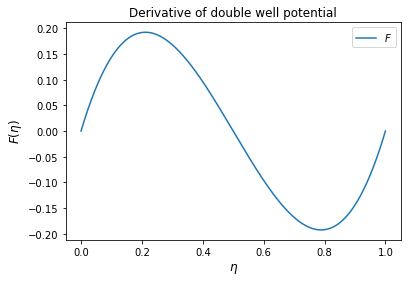

In [8]:
'''
F : lambda function computing the derivative of the double well potential at a point.
'''
F = lambda x : 2. * x * ( 2. * x**2 - 3. * x +1. )

title("Derivative of double well potential")
_ = plot(x, F(x), label=r'$F$')
xlabel(r'$\eta$',fontsize=12)
ylabel(r'$F(\eta)$', fontsize=12)
_ = legend()

In [9]:
def compute_basis_functions(support_points, degree):
    '''
    Function computing a basis of functions wich are polynomials of input degree
    on the sub-intervals defined by the support points.
    
    Input : * 1D ndarray support_points, points in interval giving support points for constructing 
                                         basis of piecewise polynomial objects.
            * int degree, specifies degree of the spline fit on each sub-interval.
    
    Output: * list basis, list of piecewise polynomials (objects of class scipy.interpolate.PPoly) 
                          giving basis of space of piecewise polynomials. 
    '''
    basis = []
    m = support_points.shape[0]
    for i in range(m):
        c = zeros(m)
        c[i] = 1
        bi = PPoly.from_spline(splrep(support_points,c,k=degree))
        basis.append(bi)
    
    return basis

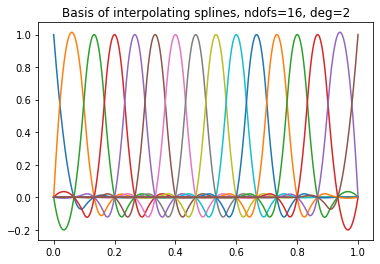

In [10]:
q = linspace(0,1,16)
def evaluate_list_functions(x, list_functions):
    '''
    Function evaluating a list of functions at prescribed points.
    
    Input : * 1D ndarray x, points for evaluation.
            * list list_functions, list of functions to be evaluated.
    
    Output: * numpy array E, evaluation of i-th function in list in x placed in column i. 
    '''
    N = x.shape[0]
    M = len(list_functions)
    E = zeros((N, M))
    for i in range(M):
        E[:,i] = list_functions[i](x)
    return E

title("Basis of interpolating splines, ndofs=16, deg=2")
_ = plot(x, evaluate_list_functions(x,compute_basis_functions(q,2)))

In [11]:
def compute_global_quadrature(basis, n_gauss_quadrature_points):
    '''
    Function computing quadrature points and quadrature weights needed for exact integration 
    of functions in span([bi for bi in basis]) over the domain [0,1]. 
    
    Input : * list basis, list of objects of class scipy.interpolate.PPoly defining some piecewise subdivision, 
                          for instance as given by piecewise polynomial basis.
            * int n_gauss_quadrature_points, number of sample points and weights for each subinterval 
                                             (d+1 if considering piecewise interpolation with degree d splines).
    
    Output: * global_quadrature, 1D ndarray containing sample points for exact integration on interval [0,1]
            * global_weights, 1D ndarray containing weigths for exact integration over [0,1]
    '''
    
    # extract interval of piecewise subdivision 
    intervals = unique(basis[0].x)
    
    # compute quadrature points and weights and rescale for interval [0,1]
    qp, w = numpy.polynomial.legendre.leggauss(n_gauss_quadrature_points)
    qp = (qp+1)/2.
    w /= 2.
    
    # replicate points and weights in all the intervals of piecewise subdivision
    h = diff(intervals)
    global_quadrature = array([intervals[i]+h[i]*qp for i in range(len(h))]).reshape((-1,))
    global_weights = array([w*h[i] for i in range(len(h))]).reshape((-1,))
    
    return global_quadrature, global_weights

In [12]:
def compute_system_matrices(basis, global_quadrature, global_weights):
    '''
    Function computing matrices describing evolution of the system.
    
    Input : * list basis, list of objects of class scipy.interpolate.PPoly defining some piecewise subdivision, 
                          for instance as given by piecewise polynomial basis.
            * global_quadrature, 1D ndarray containing sample points for exact integration of functions in 
                                 span(bi for bi in basis) on interval [0,1].
            * global_weights, 1D ndarray containing weigths for exact integration for exact integration of 
                              functions in span(bi for bi in basis) on interval [0,1].
            
    
    Output: * numpy array M, matrix (v_i,v_j)_ij containing the inner product of the basis functions.   
            * numpy array K, matrix (v'_i,v'_j)_ij containing the inner product of the derivatives of 
              the basis functions.
    '''
    dbasis = [b_i.derivative(1) for b_i in basis]
    Bq = array([b_i(global_quadrature) for b_i in basis]).T
    dBq = array([db_i(global_quadrature) for db_i in dbasis]).T
    M = einsum('ki, k, kj', Bq, global_weights, Bq)
    K = einsum('ki, k, kj', dBq, global_weights, dBq)

    return M, K

### Solve Allan-Cahn via linear and non-linear solver (step 2 and 4)

#### LINEAR SOLVER

In [13]:
def solve_allen_cahn(eta_0_function, eps, dt, ndofs, degree, T):
    '''
    Function computing evolution of the system via linear solver.
    
    Input : * eta_zero_function, function computing the potential.
            * eps, parameter regulating stiffness.
            * dt, basic time step.
            * ndofs, number of 
            * degree, degree of interpolating splines.
            * T, final time.
            
    
    Output: * numpy array eta, matrix containing in i-th row the value of the solution 
              at interpolating points.   
            * numpy array basis, matrix containing the evaluation of the basis functions 
              at the interpolating points.
    '''
    ## prepare matrix for results
    n_times = int(T/dt)
    eta = zeros((n_times+1, ndofs))
    
    # calculate time independent parts of the system
    support_points = linspace(0,1, ndofs)
    basis = compute_basis_functions(support_points, degree)
    Q, W = compute_global_quadrature(basis, degree + 1)
    M, K = compute_system_matrices(basis, Q, W)
    A = M + dt * eps**2 * K
    eta[0,:] = eta_0_function(support_points)
    
    # solve linear system for n_times iterations
    for i in range(n_times):
        rhs = M.dot(eta[i,:] - dt * F(eta[i,:]))
        eta[i+1,:] = linalg.solve(A, rhs)
        
    return eta, basis    

#### NON-LINEAR SOLVER

**NOTE**: commented computation fo eta_next via classic Newton method in non-linear solver results unstable with Scipy version 1.2.1, replaced with newton_krylov method which do not depend on choice of version.

In [14]:
def solve_allen_cahn_nonlinear(eta_0_function, eps, dt, ndofs, degree, T):
    '''
    Function computing evolution of the system via non-linear solver.
    
    Input : * eta_zero_function, function computing the potential.
            * eps, parameter regulating stiffness.
            * dt, basic time step.
            * ndofs, number of 
            * degree, degree of interpolating splines.
            * T, final time.
            
    
    Output: * numpy array eta, matrix containing in i-th row the value of the solution 
              at interpolating points.   
            * numpy array basis, matrix containing the evaluation of the basis functions 
              at the interpolating points.
    '''
    ## prepare matrix for results
    n_times = int(T/dt)
    eta = zeros((n_times+1, ndofs))
    
    # calculate time independent parts of the system
    support_points = linspace(0,1, ndofs)
    basis = compute_basis_functions(support_points, degree)
    Q, W = compute_global_quadrature(basis, degree + 1)
    M, K = compute_system_matrices(basis, Q, W)
    
    eta_tmp = eta_0_function(support_points)
    eta[0,:] = eta_tmp
    
    # solve non-linear system for n_times iterations
    for i in range(1, n_times+1):
        

        #eta_next = scipy.optimize.newton(lambda x : M.dot(x + dt*F(x)) + eps**2*dt*K.dot(x) - M.dot(eta_tmp), eta_tmp, maxiter = 200)
        eta_next = scipy.optimize.newton_krylov(lambda x : M.dot(x + dt*F(x)) + eps**2*dt*K.dot(x) - M.dot(eta_tmp), eta_tmp, maxiter = 200)        
        eta[i,:] = eta_next
        eta_tmp=eta_next
    return eta, basis    

#### Basic plot of solutions

In [15]:
def plot_solution(eta, basis, stride, resolution, title="", ylab="", legend = False, option = False):
    '''
    Function plotting solutions.
    
    Input : * eta, matrix of solutions.
            * basis, .
            * dt, basic time step.
            * ndofs, number of 
            * degree, degree of interpolating splines.
            * T, final time.
            
    
    Output: * numpy array eta, matrix containing in i-th row the value of the solution 
              at interpolating points.   
            * numpy array basis, matrix containing the evaluation of the basis functions 
              at the interpolating points.
    '''
    x = linspace(0,1,resolution)
    eta_plot = (evaluate_list_functions(x,basis).dot(eta.T))[:,::stride]
    colors = cm.coolwarm(np.linspace(0,1,eta_plot.shape[1]))
    times = linspace(0,1,eta.shape[0])
    eff_times = times[::stride]
    
    for i in range(eta_plot.shape[1]):
        plot(x, eta_plot[:,i],  color=colors[i], label = "t ="+(str(eff_times[i])))
    if(option):
        title+=", stride "+str(stride)+", resolution "+str(resolution)
    plt.xlabel("x", fontsize = 14)
    if(ylab == ""):
        ylab = r'$\eta_{t}$(x)'
    
    plt.ylabel(ylab, fontsize = 14)
    plt.title(title)
    if(legend):
        plt.legend()

#### Linear solver example

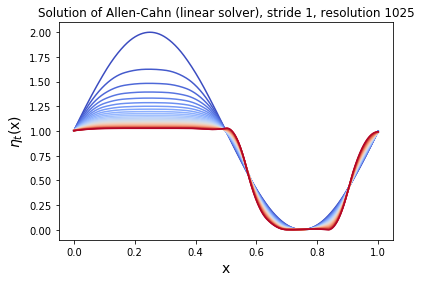

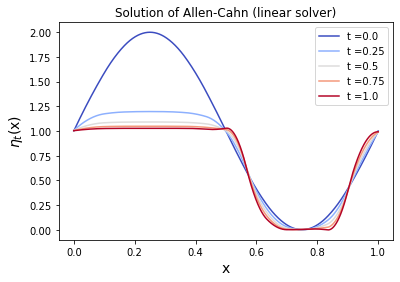

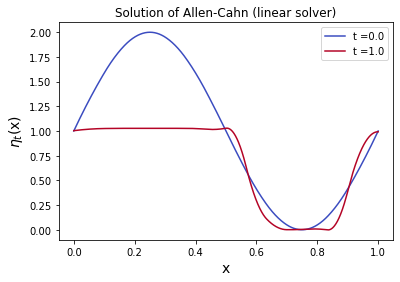

In [16]:
eps=0.01
dt = 1./32
ndofs = 16
degree= 2
title = "Solution of Allen-Cahn (linear solver)"
T=1.0
eta, b = solve_allen_cahn(eta_zero, eps, dt, ndofs, degree,T)

res=1025
stride=1
figure()
plot_solution(eta, b, stride, res, title=title, option=True )

res=1025
stride=8
figure()
plot_solution(eta, b, stride, res, title=title, legend=True)

res=1025
stride=int(1./dt)
figure()
plot_solution(eta, b, stride, res, title=title, legend = True)

#### Non-linear solver example

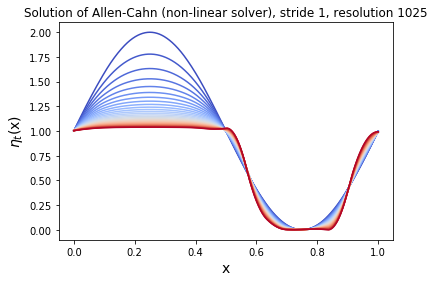

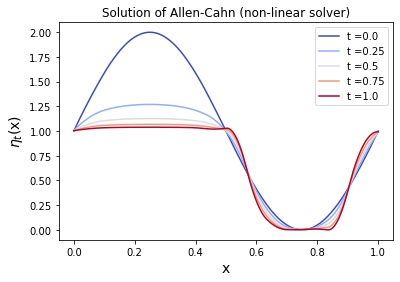

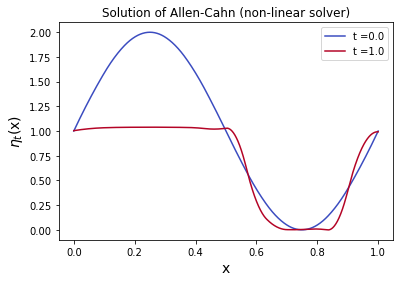

In [17]:
eps=0.01
dt = 1./32
ndofs = 16
degree= 2
title = "Solution of Allen-Cahn (non-linear solver)"
eta_nl, b_nl = solve_allen_cahn_nonlinear(eta_zero, eps, dt, ndofs, degree,T)

res=1025
stride=1
figure()
plot_solution(eta_nl, b_nl, stride, res, title=title, option=True, legend=False)

res=1025
stride=8
figure()
plot_solution(eta_nl, b_nl, stride, res, title=title, legend=True)

res=1025
stride=int(1./dt)
figure()
plot_solution(eta_nl, b_nl, stride, res, title=title, legend=True)

#### Difference methods example

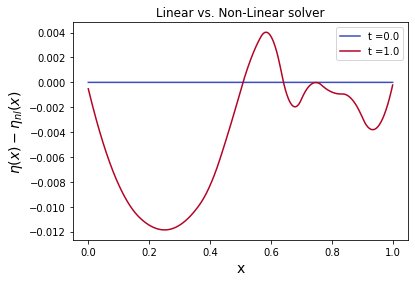

In [18]:
title = "Linear vs. Non-Linear solver"
figure()
plot_solution((eta-eta_nl), b_nl, stride, res, title=title, ylab = r'$\eta(x)-\eta_{nl}(x)$',  legend=True)

## Solutions varying parameters and method

In [41]:
def solutions(eps, degree, resolution, to_plot="linear"):
    
    dt = [.25, .125, .0625, .03125, .015625]
    ndofs = [16, 32, 64, 128]
    
    plt.figure(figsize = (20,20))

    for i in range(len(dt)):
        for j in range(len(ndofs)):
            stride = int(1./dt[i])
            ylab = ""
            
            if(to_plot == "linear"):
                title = "Linear solver, "
                eta, basis = solve_allen_cahn(eta_zero, eps, dt[i], ndofs[j], degree, 1.0)
            
            if(to_plot == "non-linear"):
                title = "Non-linear solver, "
                eta, basis = solve_allen_cahn_nonlinear(eta_zero, eps, dt[i], ndofs[j], degree,1.0)
            
            if(to_plot == "difference"):
                title = "Linear vs. non-linear, "
                ylab = r'$\eta(x)-\eta_{nl}(x)$'
                eta_l, basis = solve_allen_cahn(eta_zero, eps, dt[i], ndofs[j], degree,1.0)
                eta_nl, basis = solve_allen_cahn_nonlinear(eta_zero, eps, dt[i], ndofs[j], degree,1.0)
                eta = eta_l-eta_nl
            plt.subplot(len(dt), len(ndofs), int(len(ndofs)*i + j + 1))
            
            plot_solution(eta, basis, stride, res, title = title + " dt = " + str(dt[i]) + ", ndofs = " + str(ndofs[j]), ylab=ylab, legend = True)
            plt.tight_layout()


### eps = 0.01, degree = 1

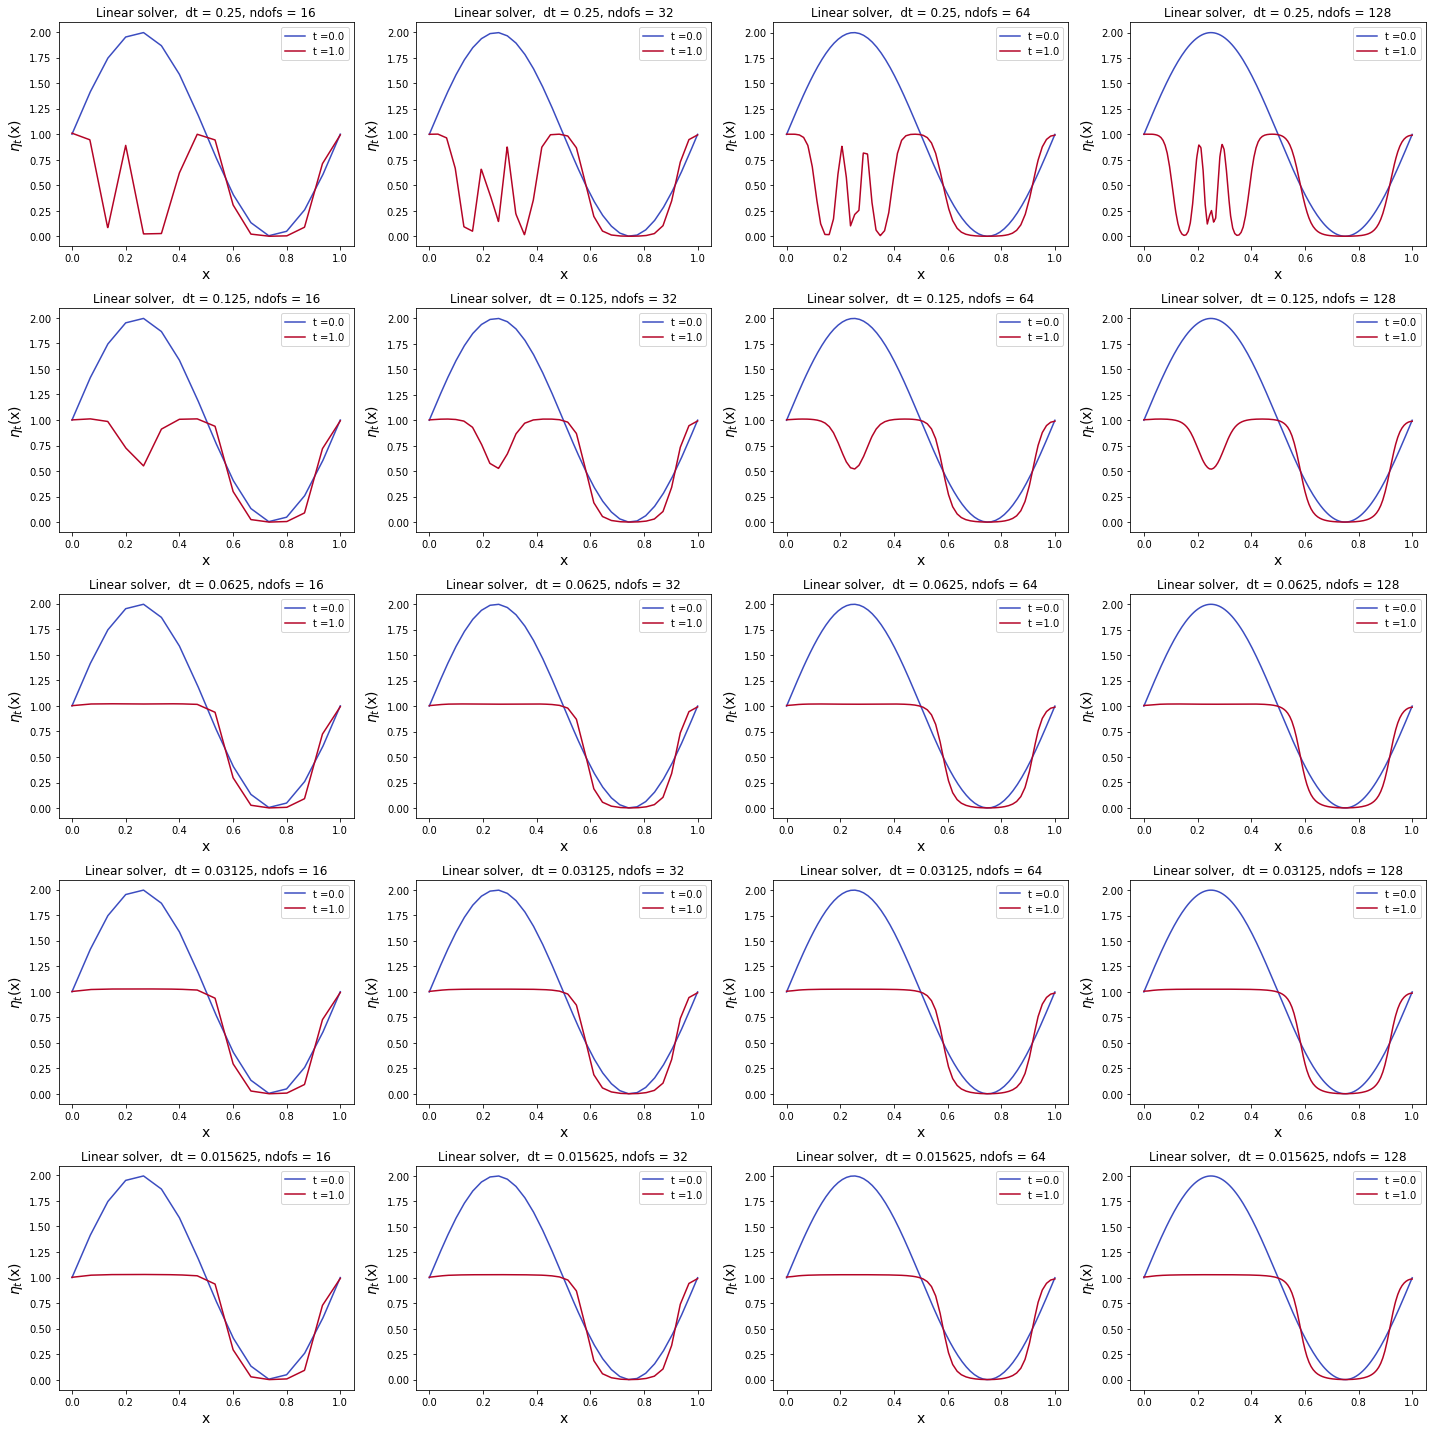

In [20]:
eps = 0.01
degree = 1
solutions(eps, degree, res, to_plot="linear")

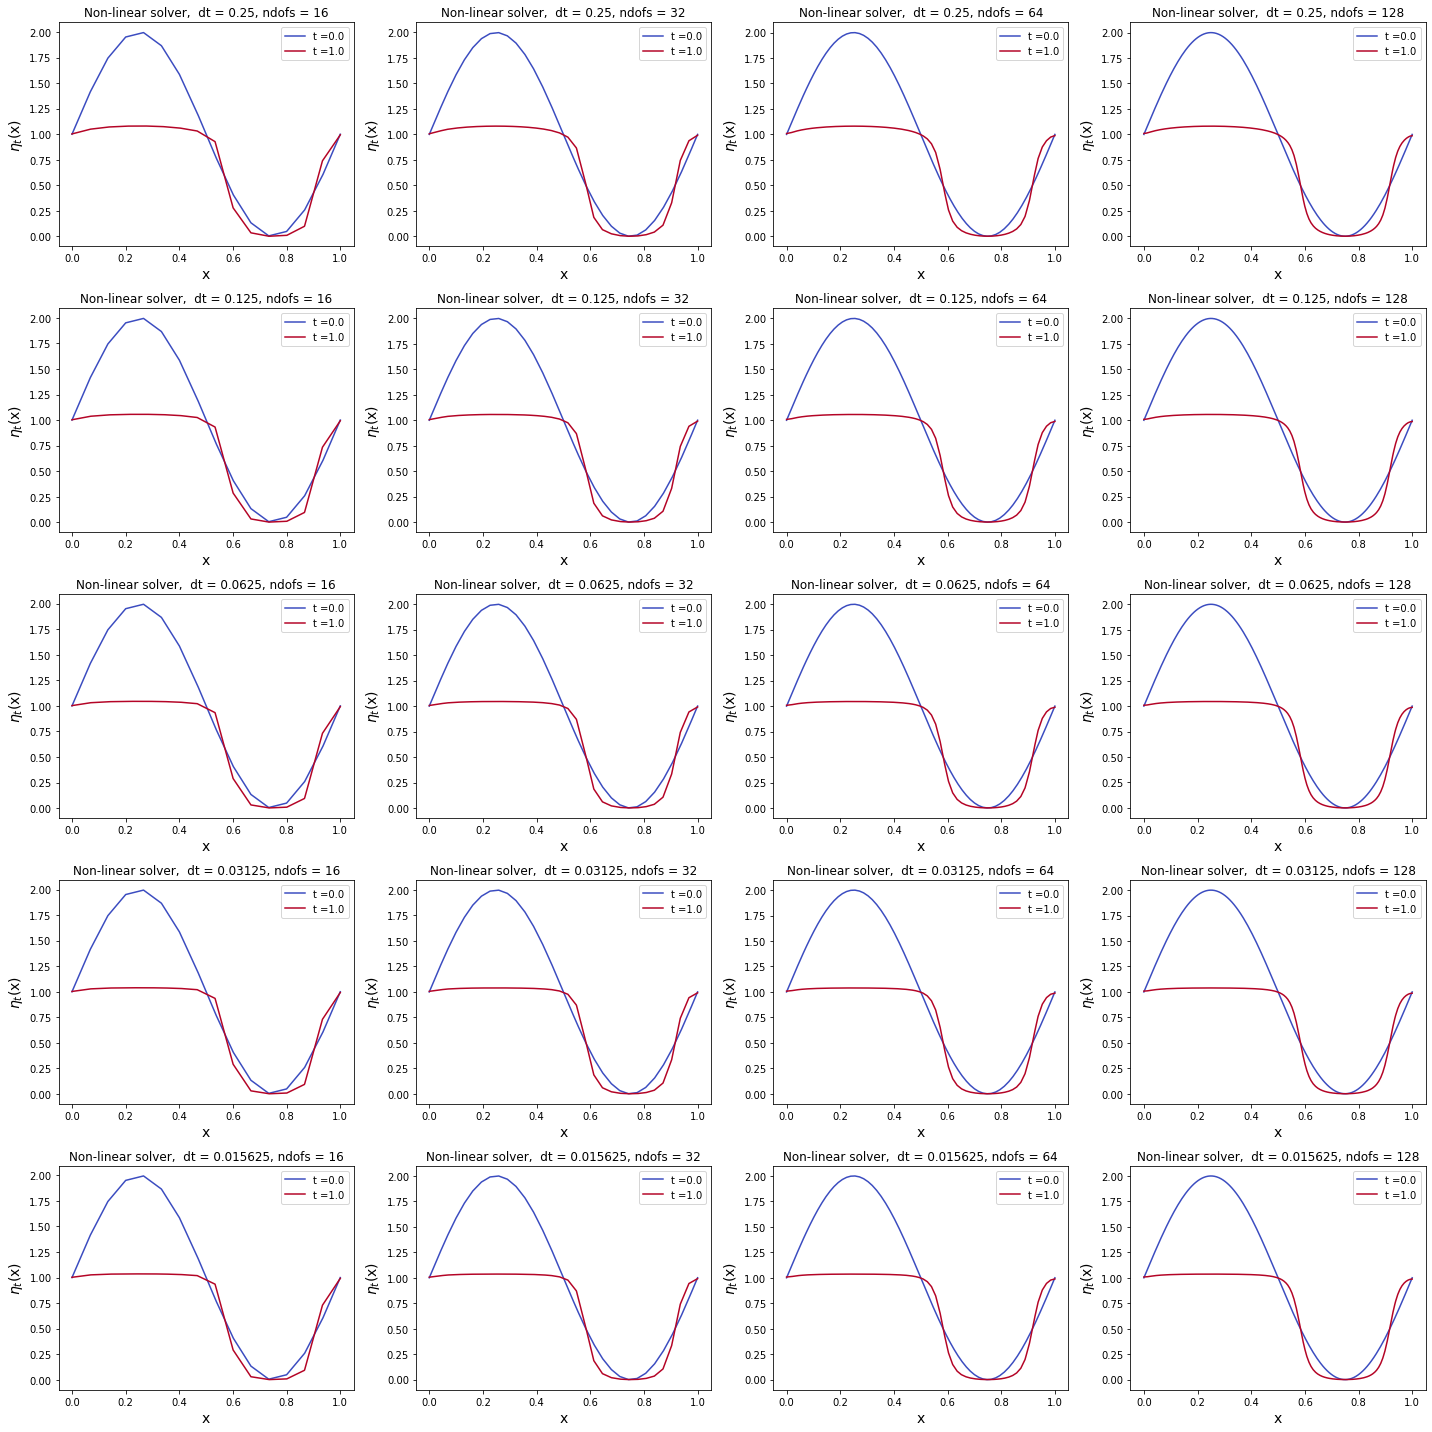

In [21]:
solutions(eps, degree, res, to_plot="non-linear")

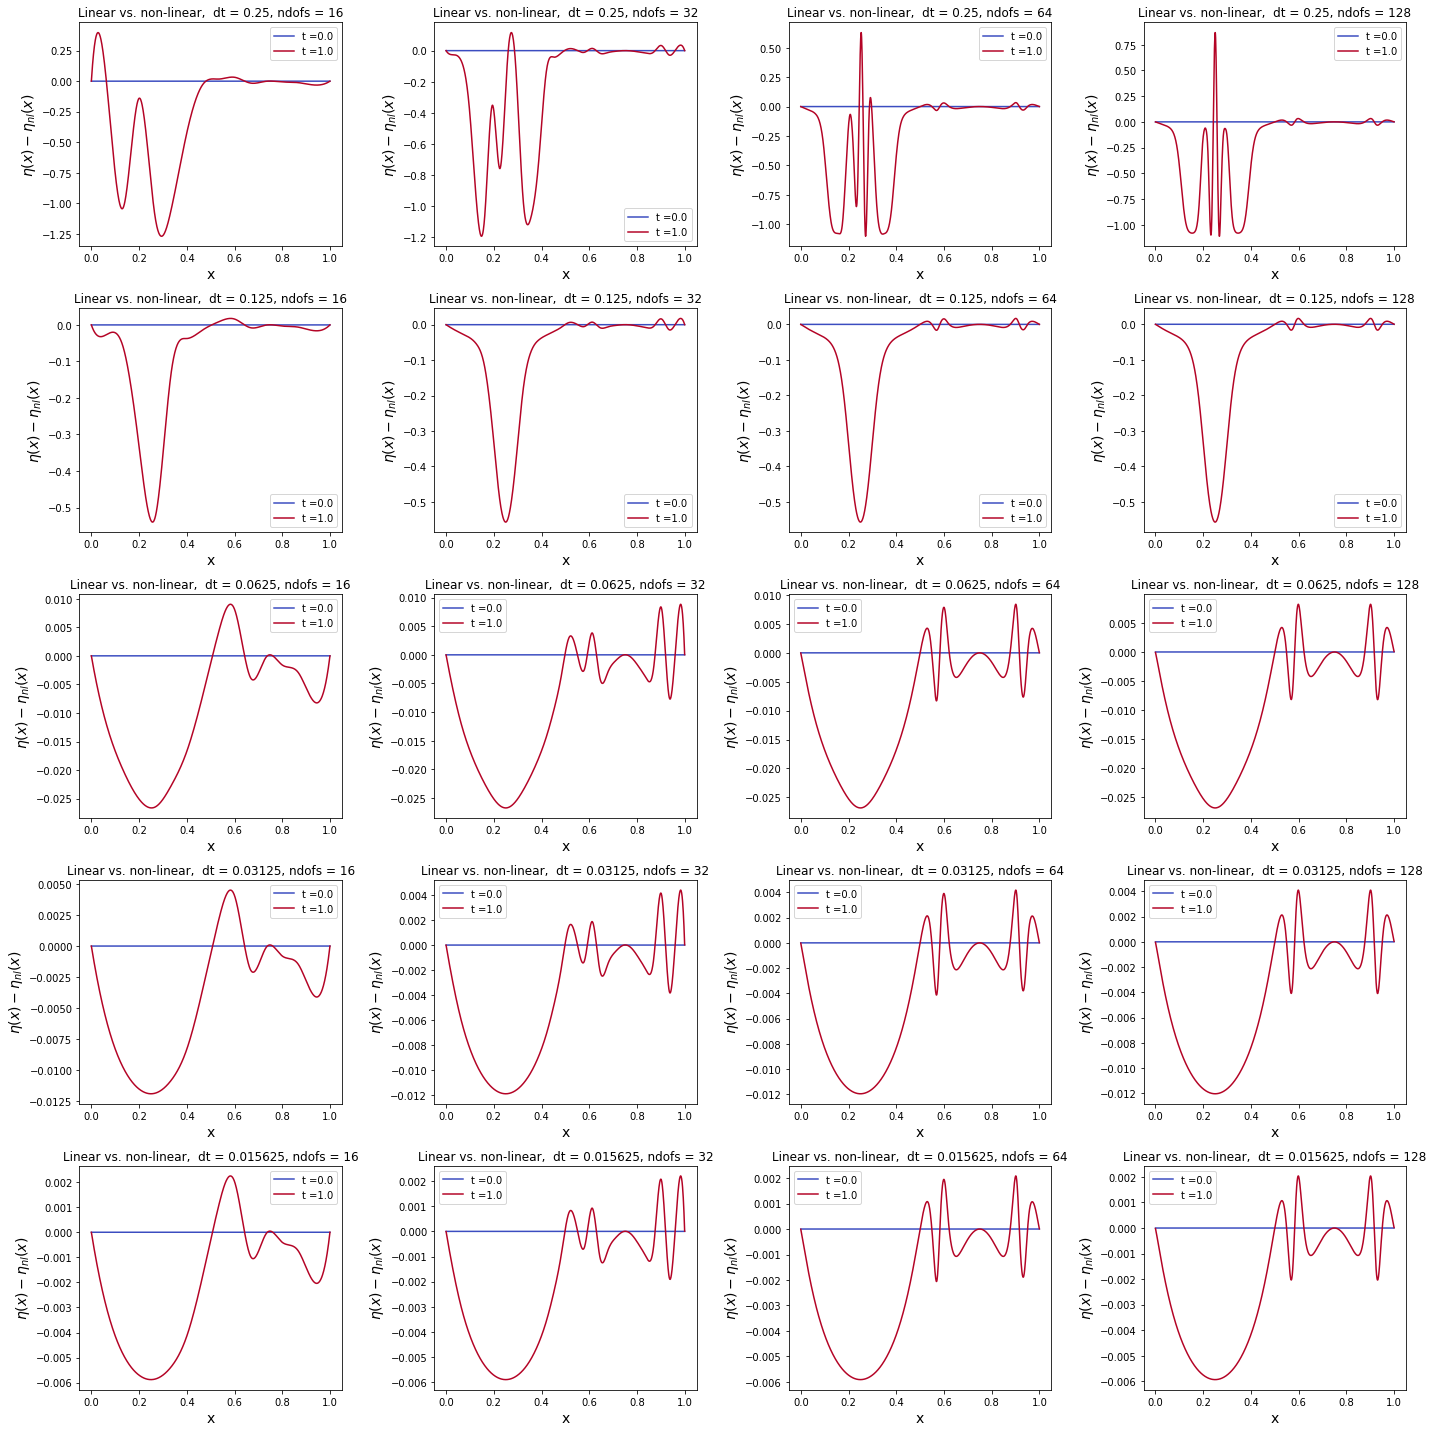

In [42]:
solutions(eps, degree, res, to_plot="difference")

### eps = 0.001, degree = 1

#### Linear

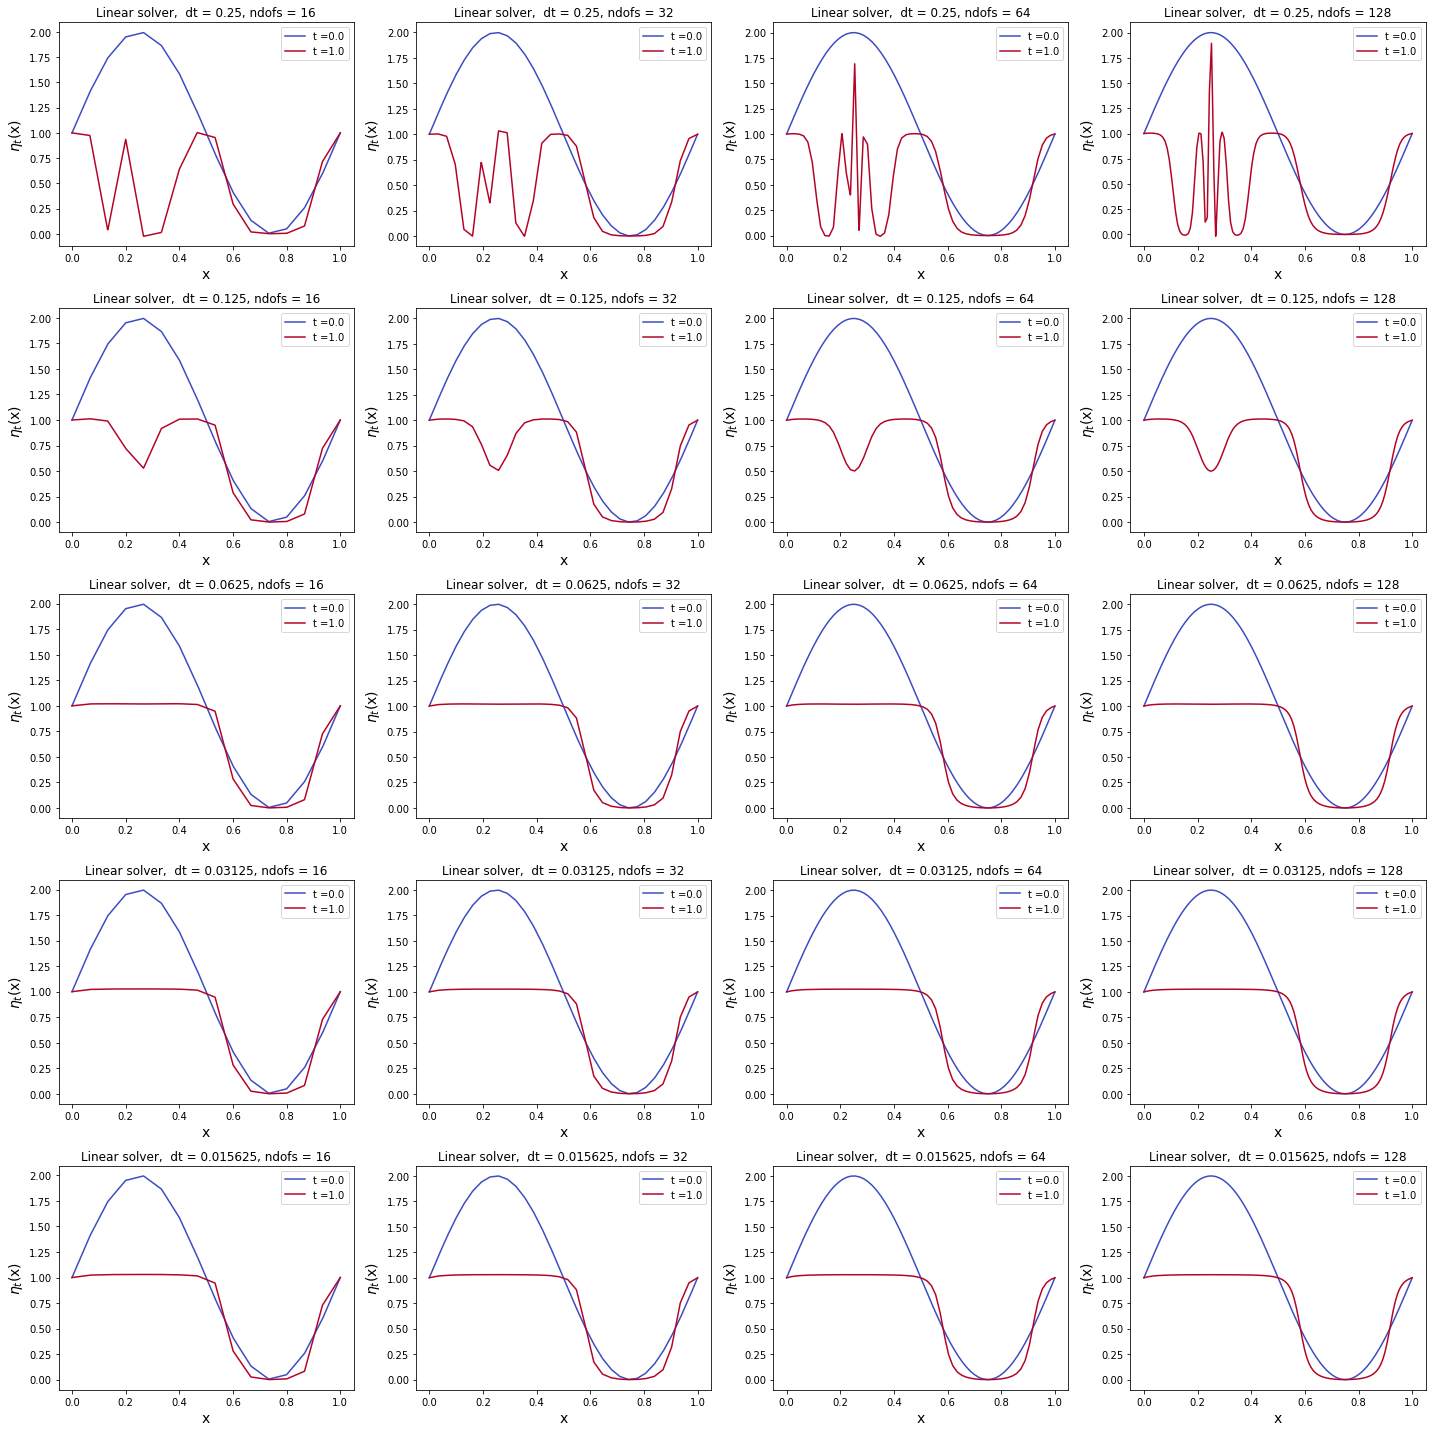

In [43]:
eps = 0.001
degree = 1
solutions(eps, degree, res, to_plot="linear")

#### Non-linear

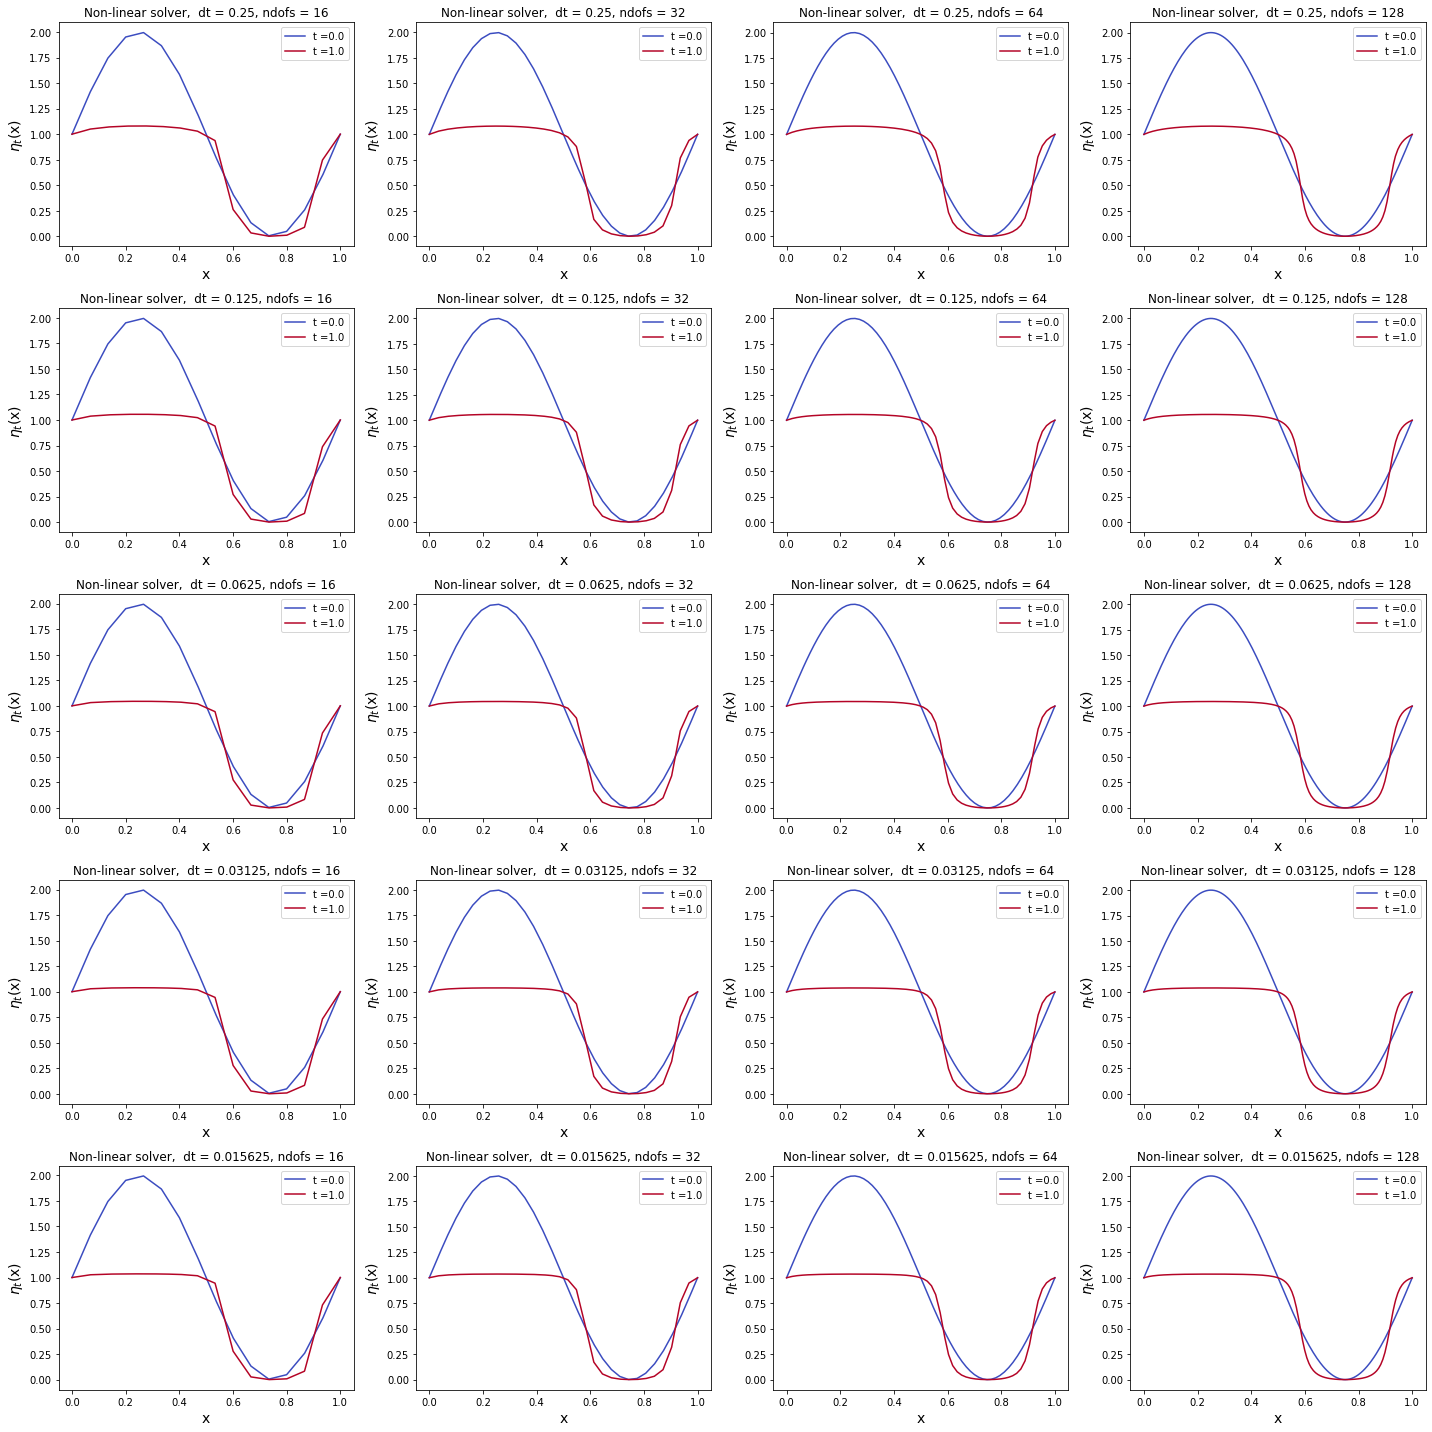

In [44]:
solutions(eps, degree, res, to_plot="non-linear")

#### Difference

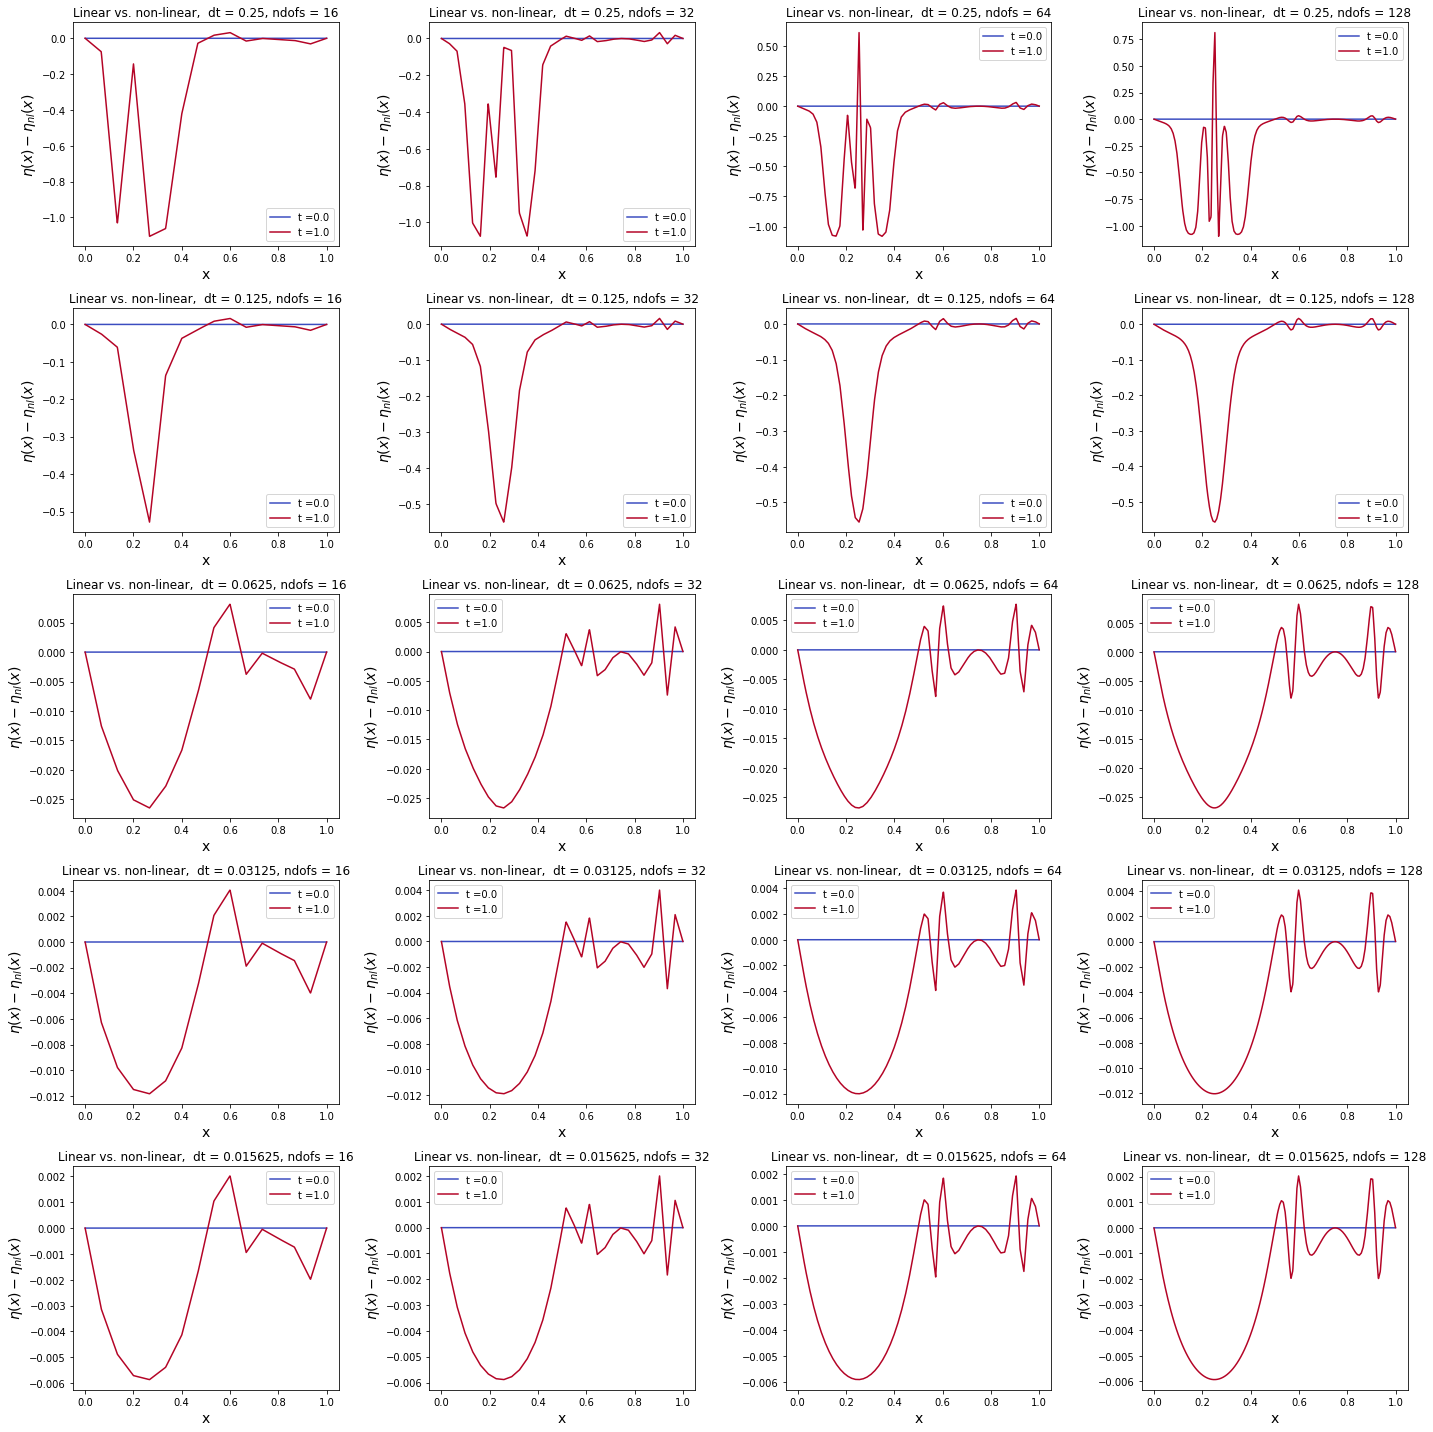

In [45]:
solutions(eps, degree, res, to_plot="difference")

### eps = 0.01, degree = 2

#### Linear

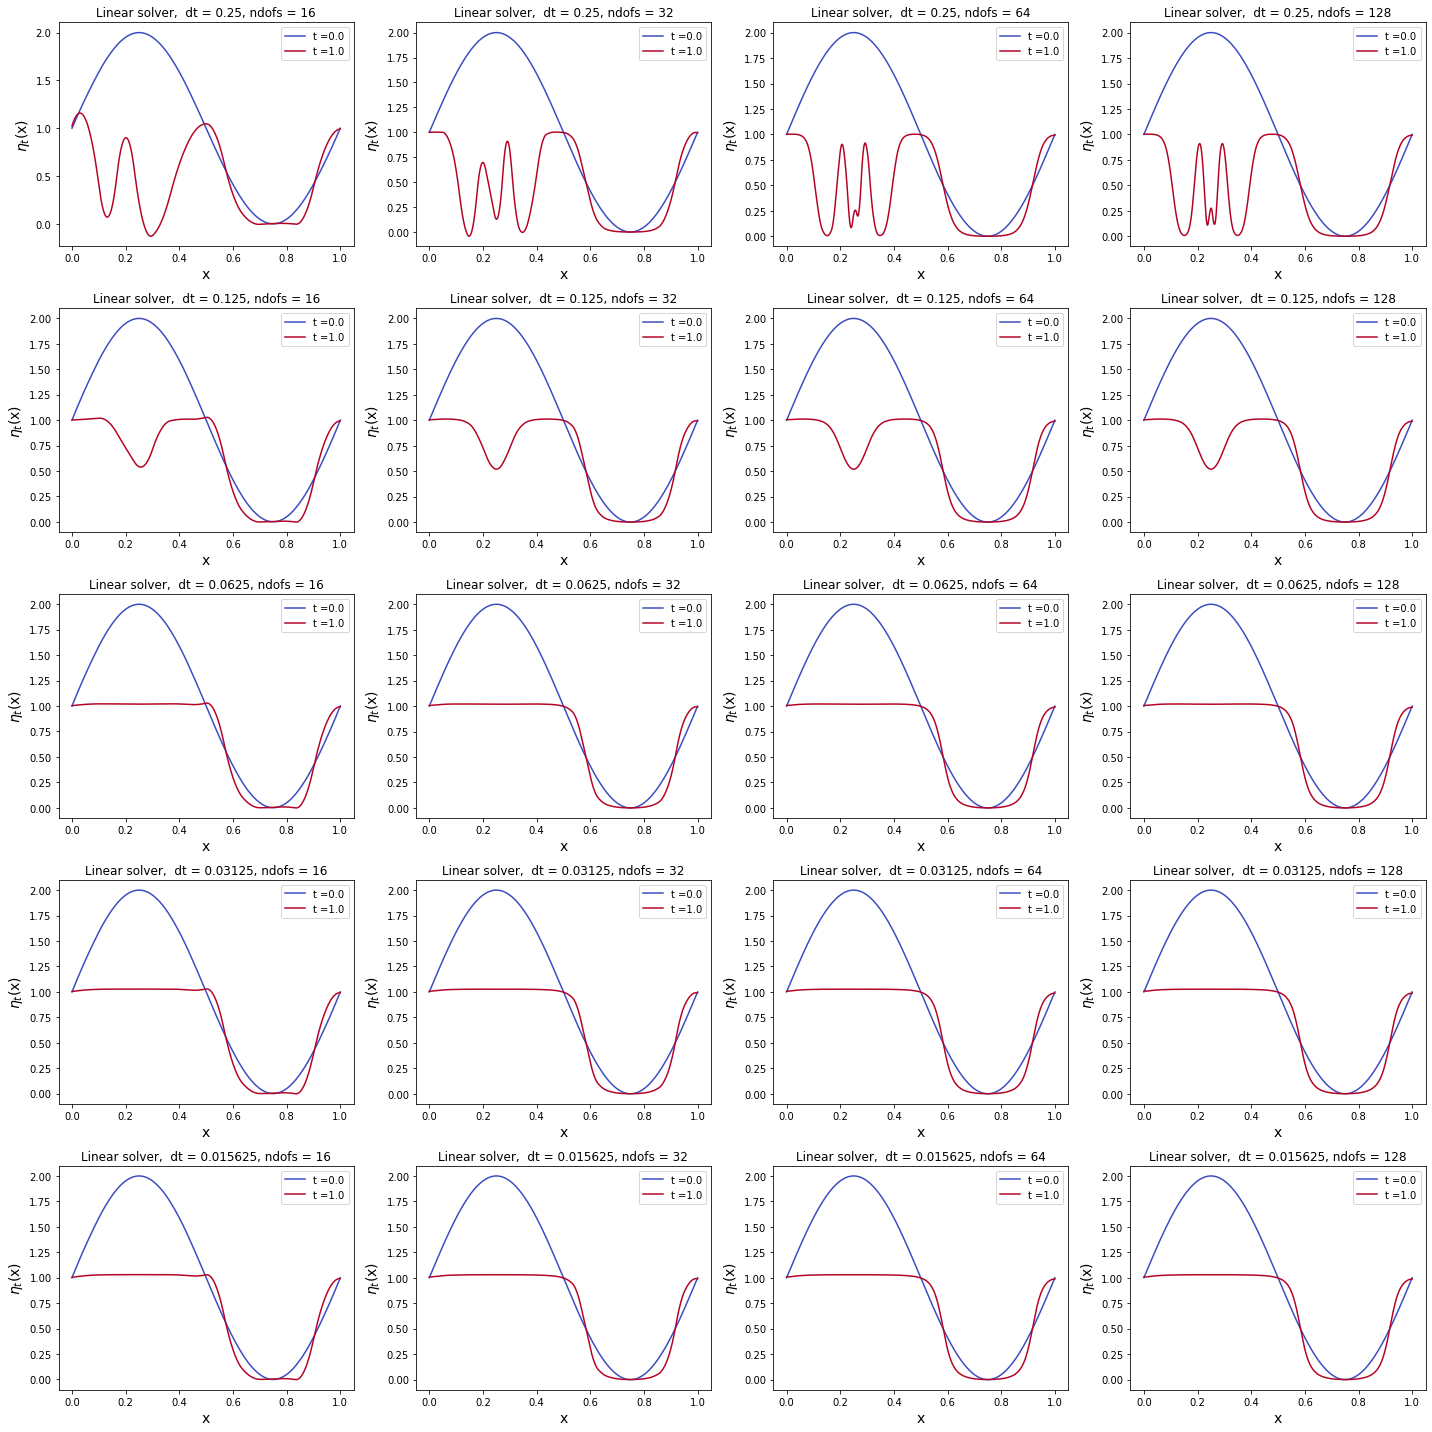

In [26]:
eps = 0.01
degree = 2
solutions(eps, degree, res, to_plot="linear")

#### Non-linear

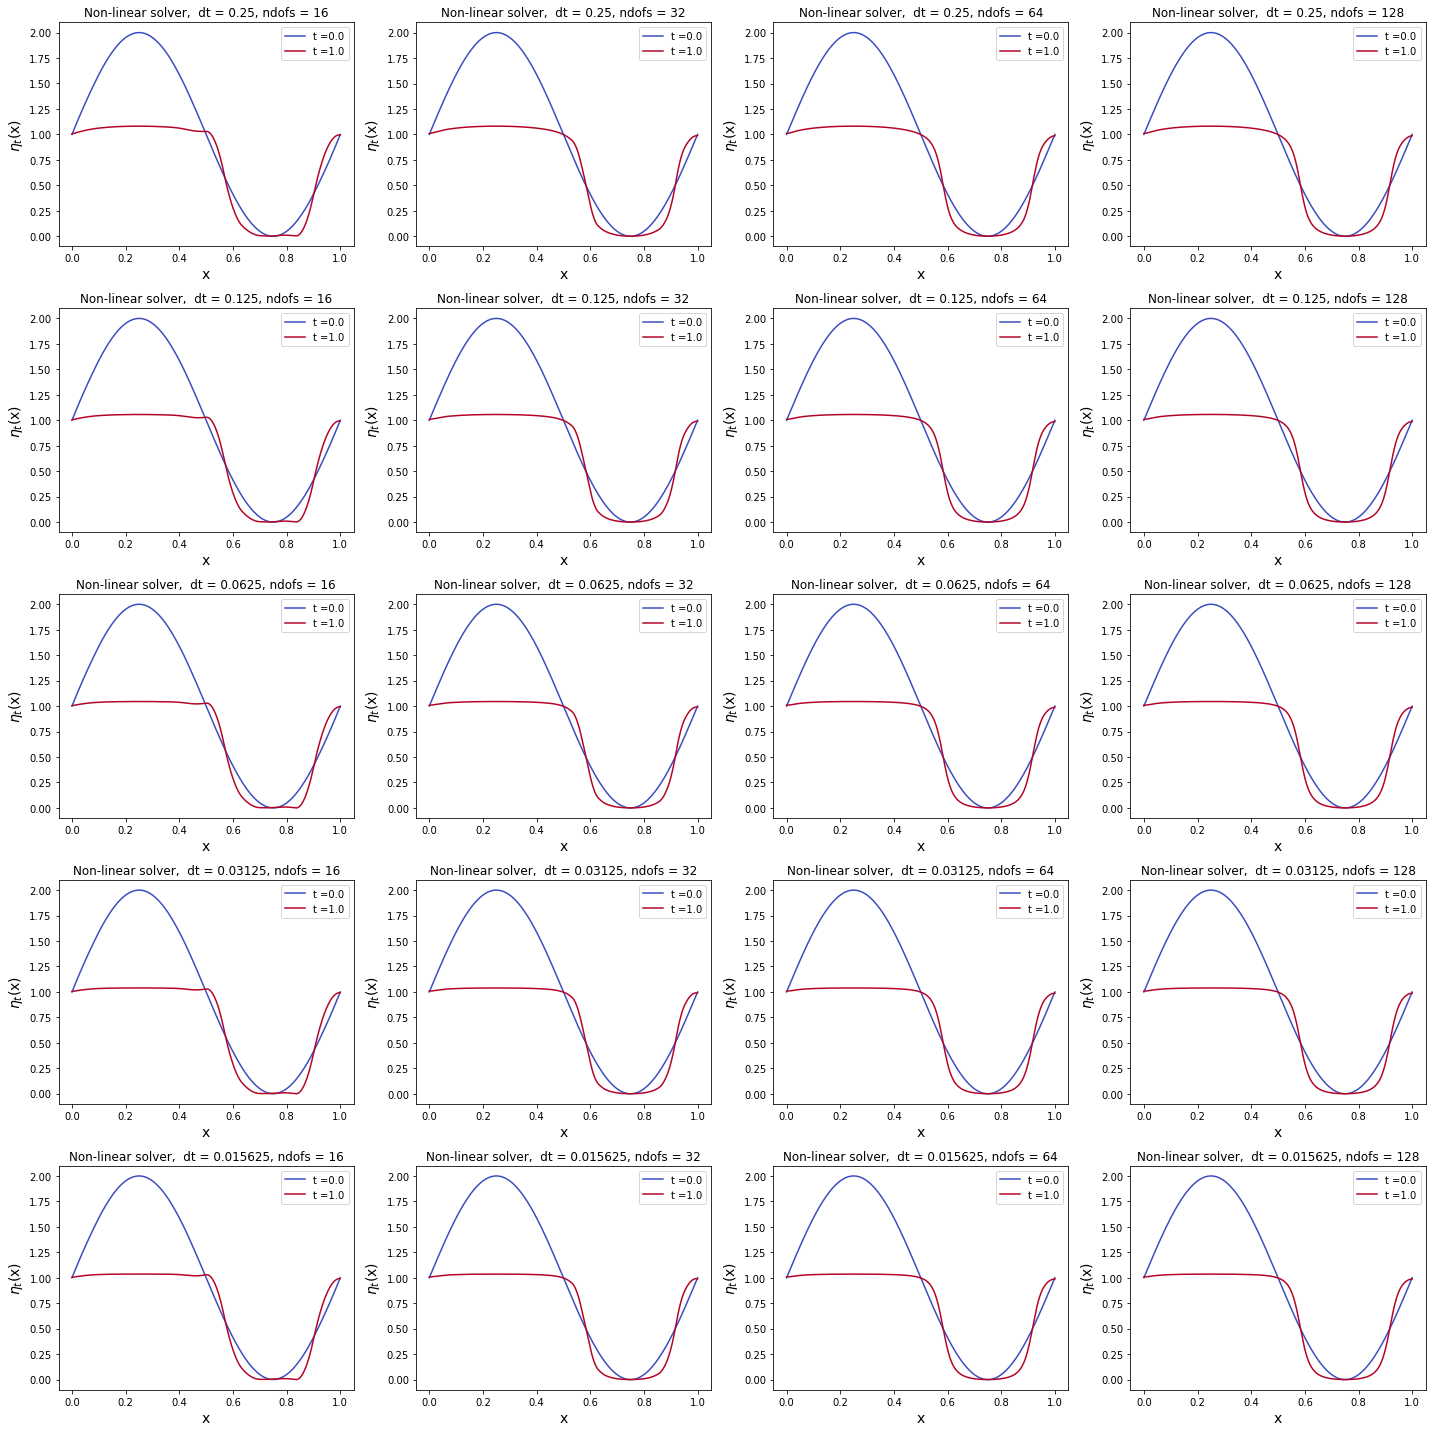

In [27]:
solutions(eps, degree, res, to_plot="non-linear")

#### Difference

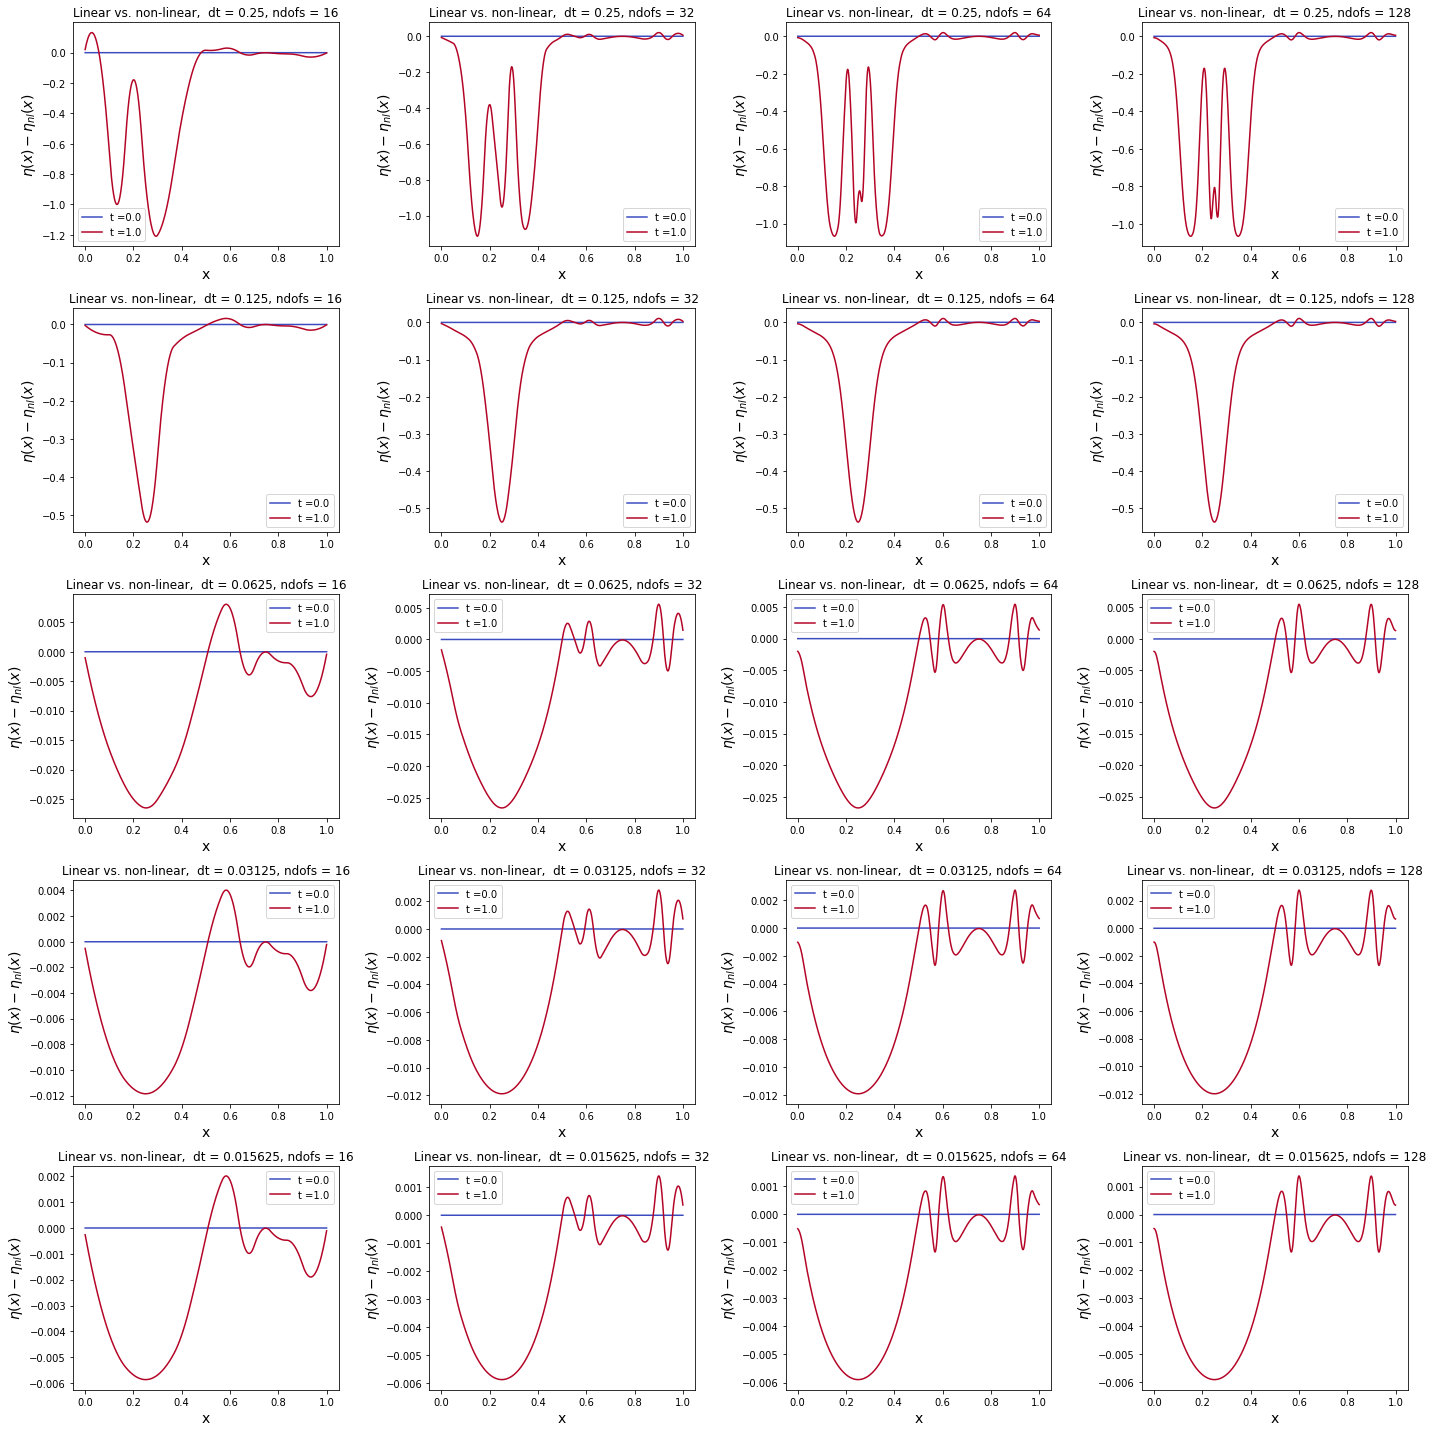

In [28]:
solutions(eps, degree, res, to_plot="difference")

### eps = 0.001, degree = 2

#### Linear

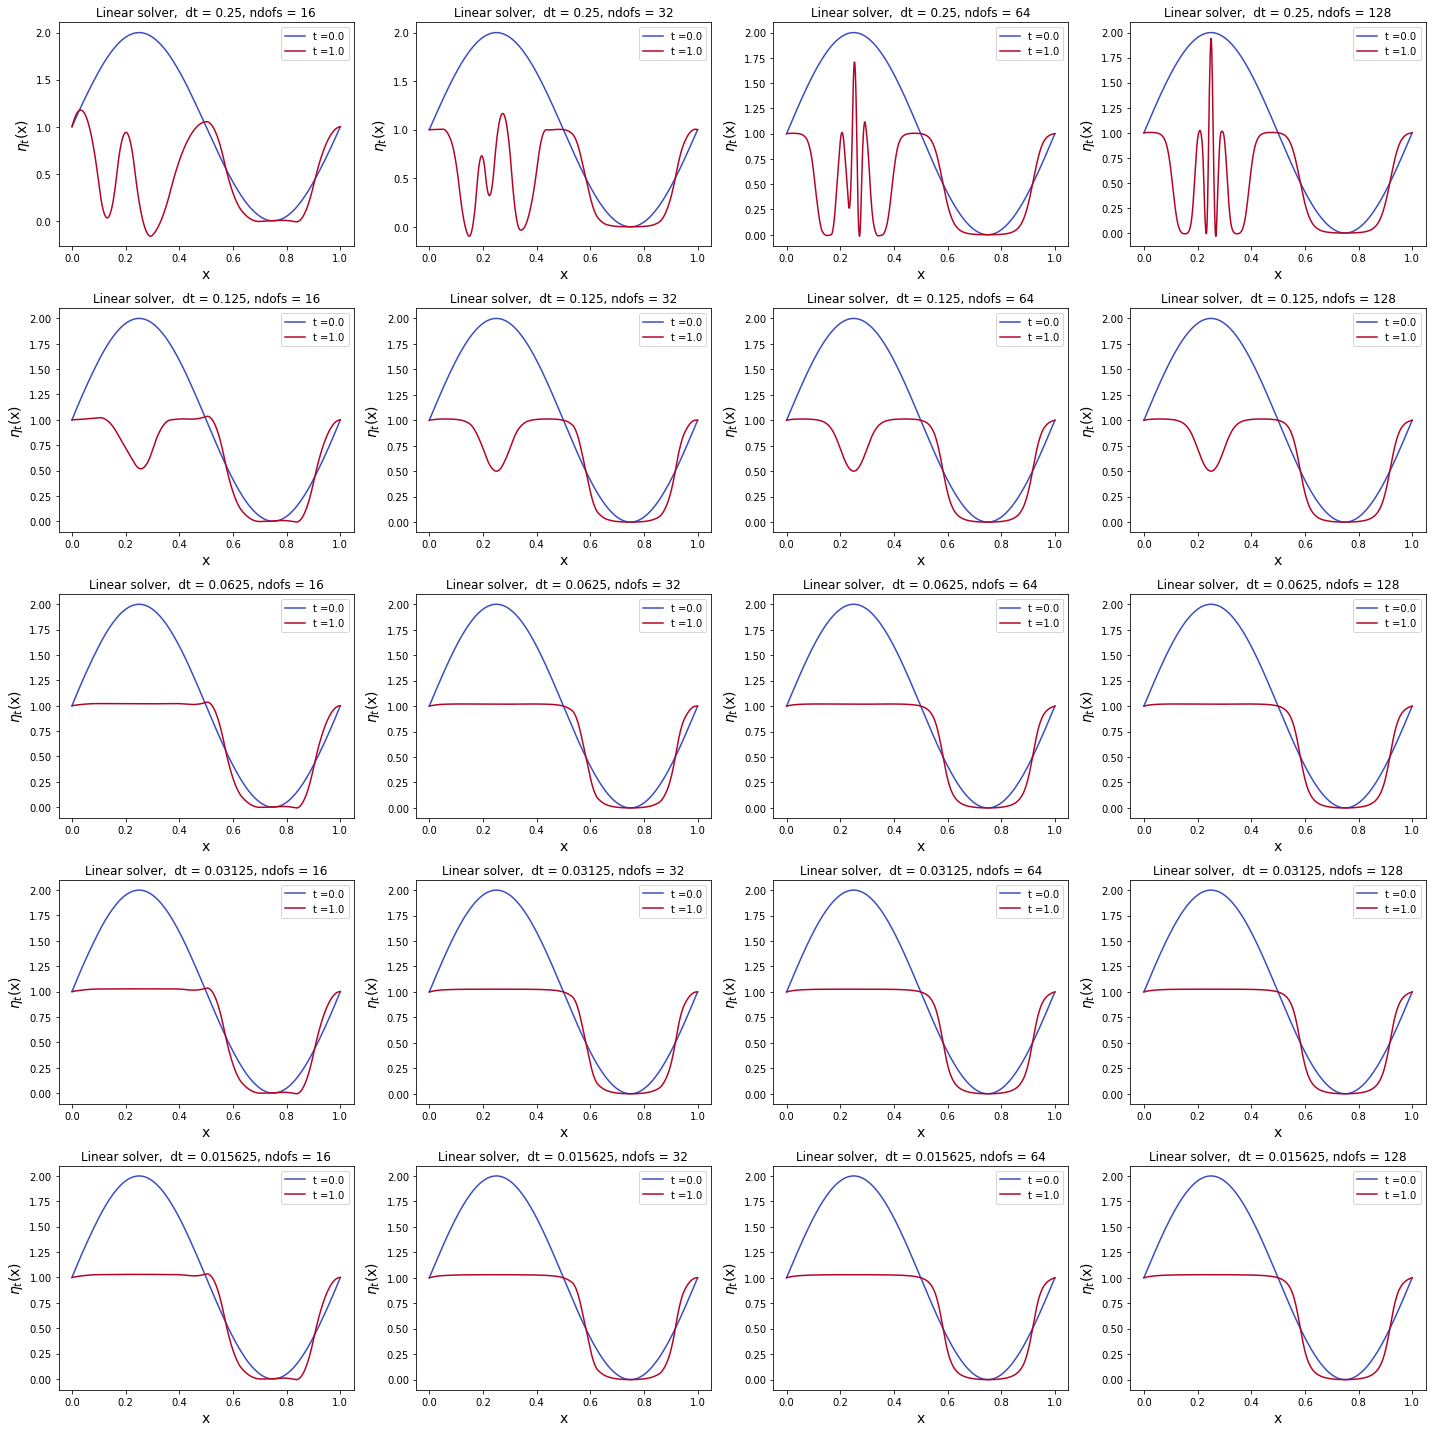

In [29]:
eps = 0.001
degree = 2
solutions(eps, degree, res, to_plot="linear")

#### Non-linear

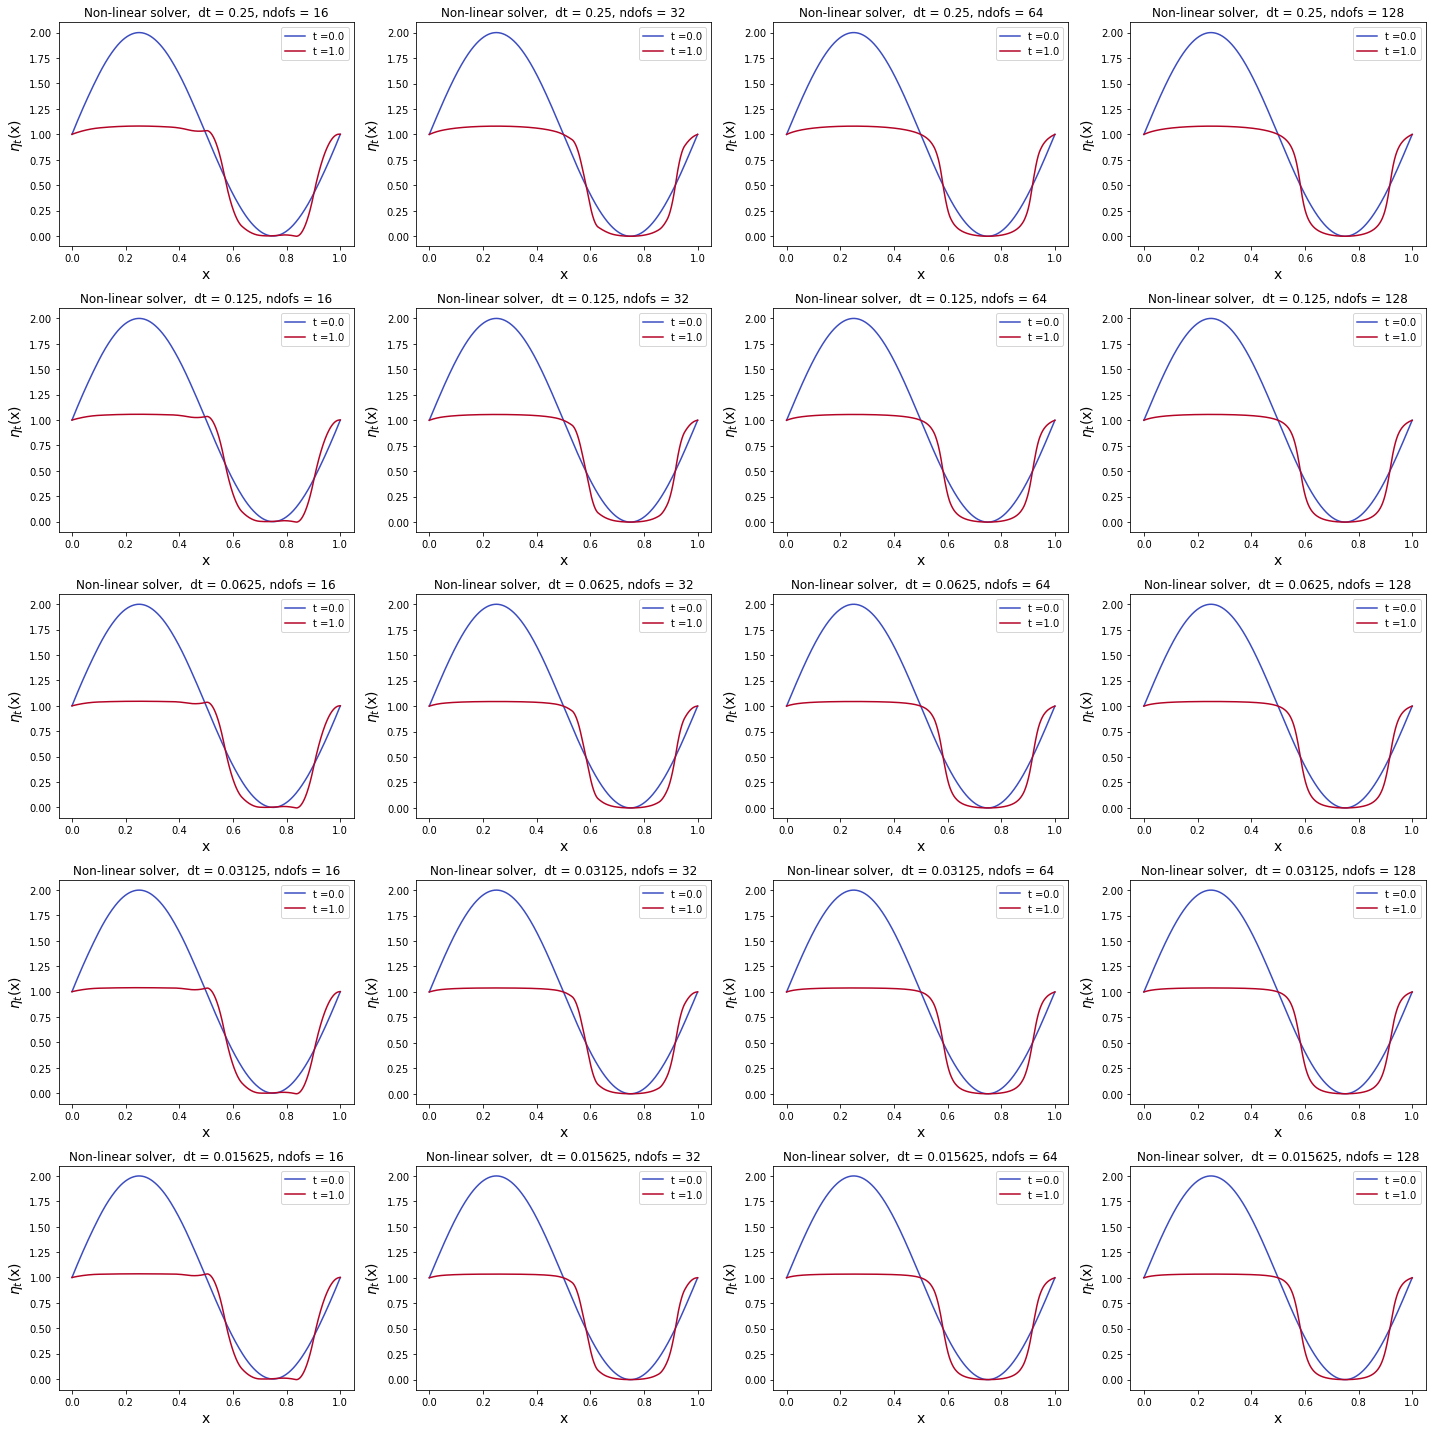

In [30]:
eps = 0.001
degree = 2
solutions(eps, degree, res, to_plot="non-linear")

#### Difference

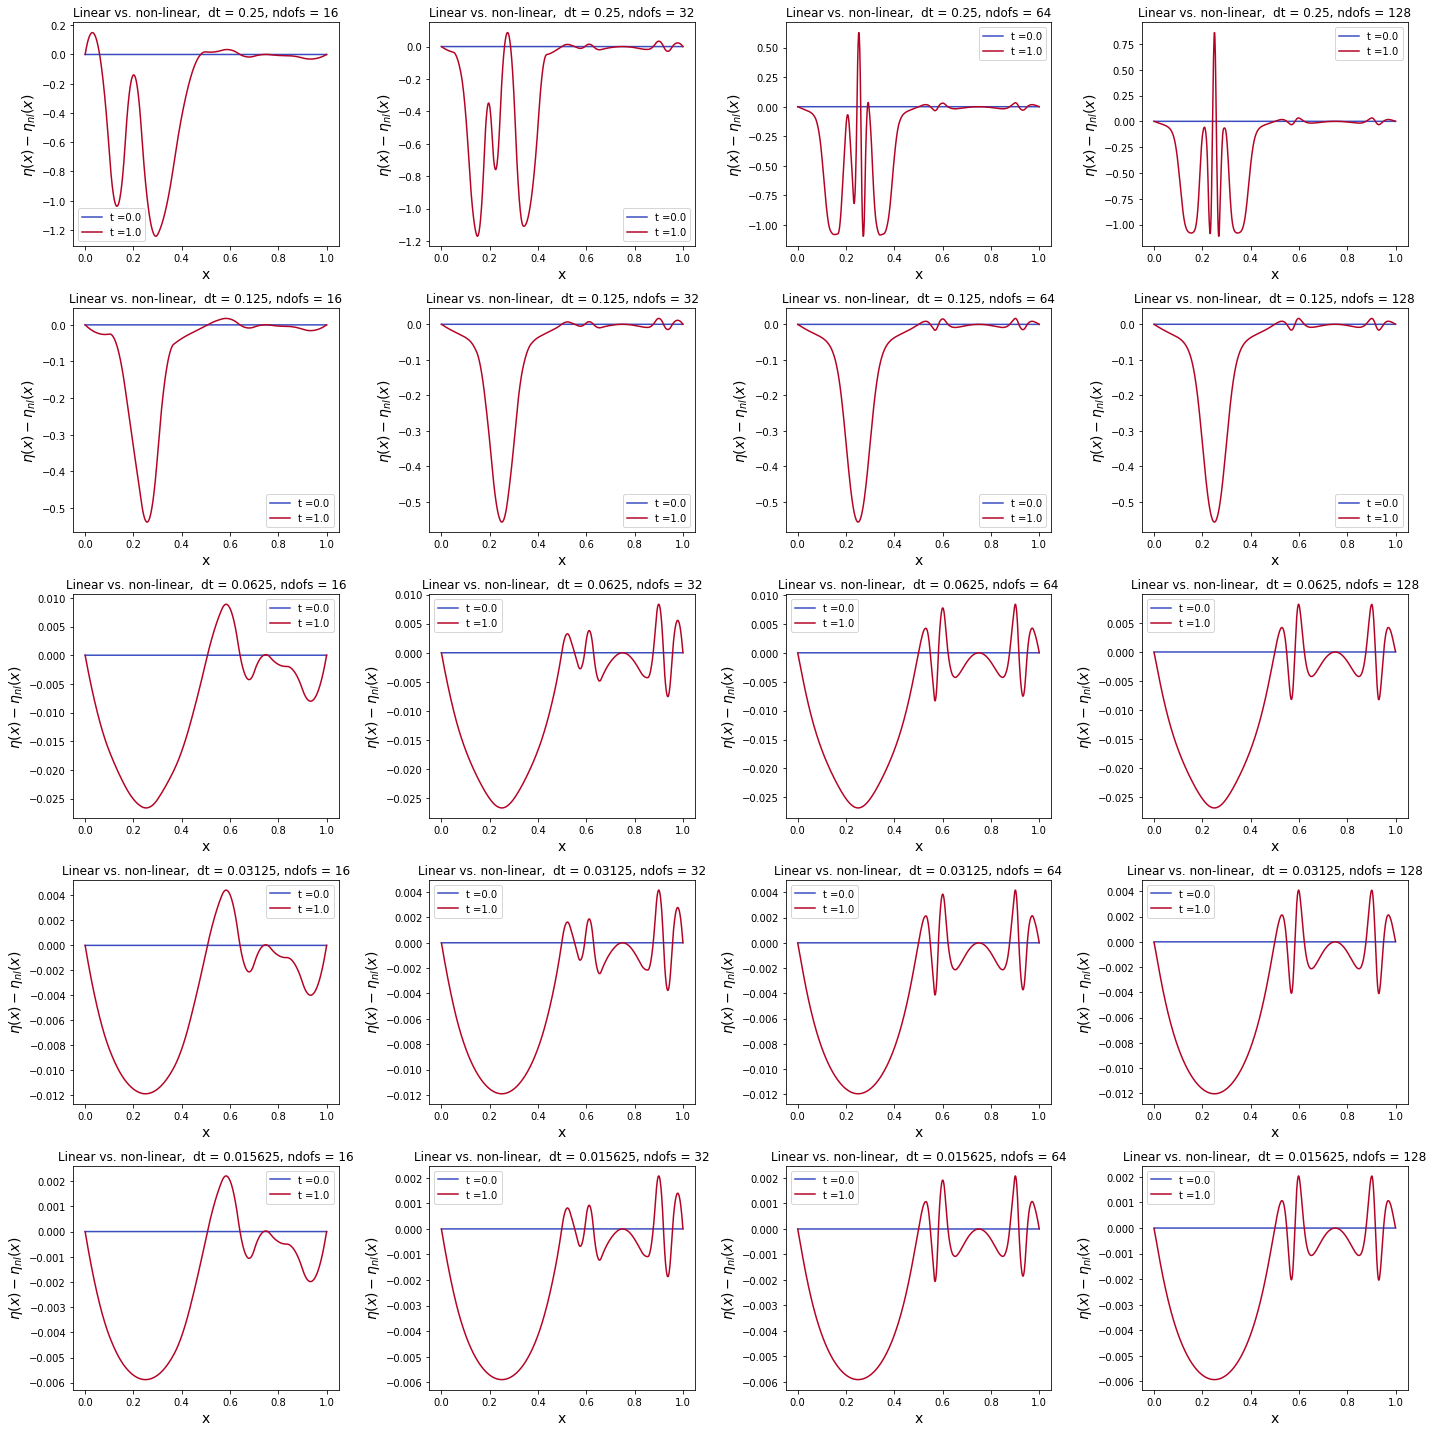

In [31]:
solutions(eps, degree, res, to_plot="difference")

### eps = 0.01, degree = 3

#### Linear

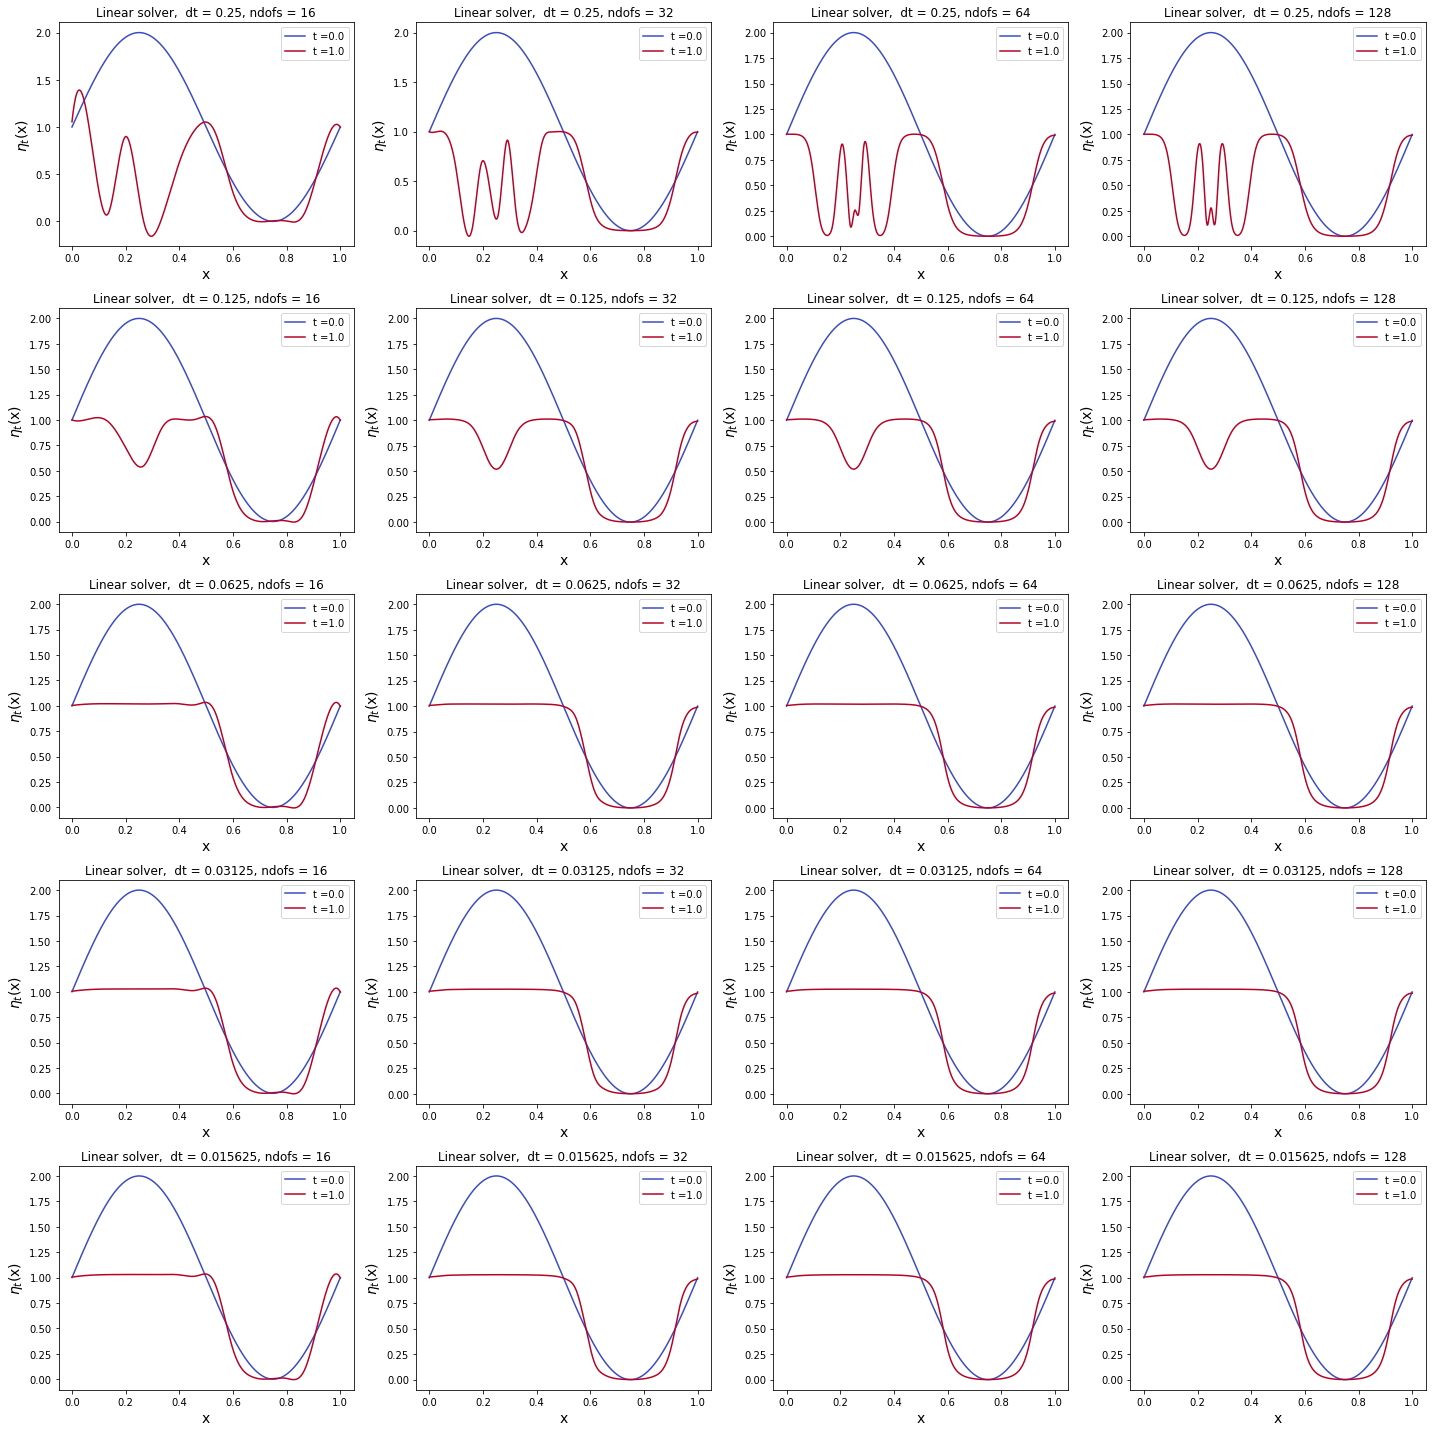

In [32]:
eps = 0.01
degree = 3
solutions(eps, degree, res, to_plot="linear")

#### Non-linear

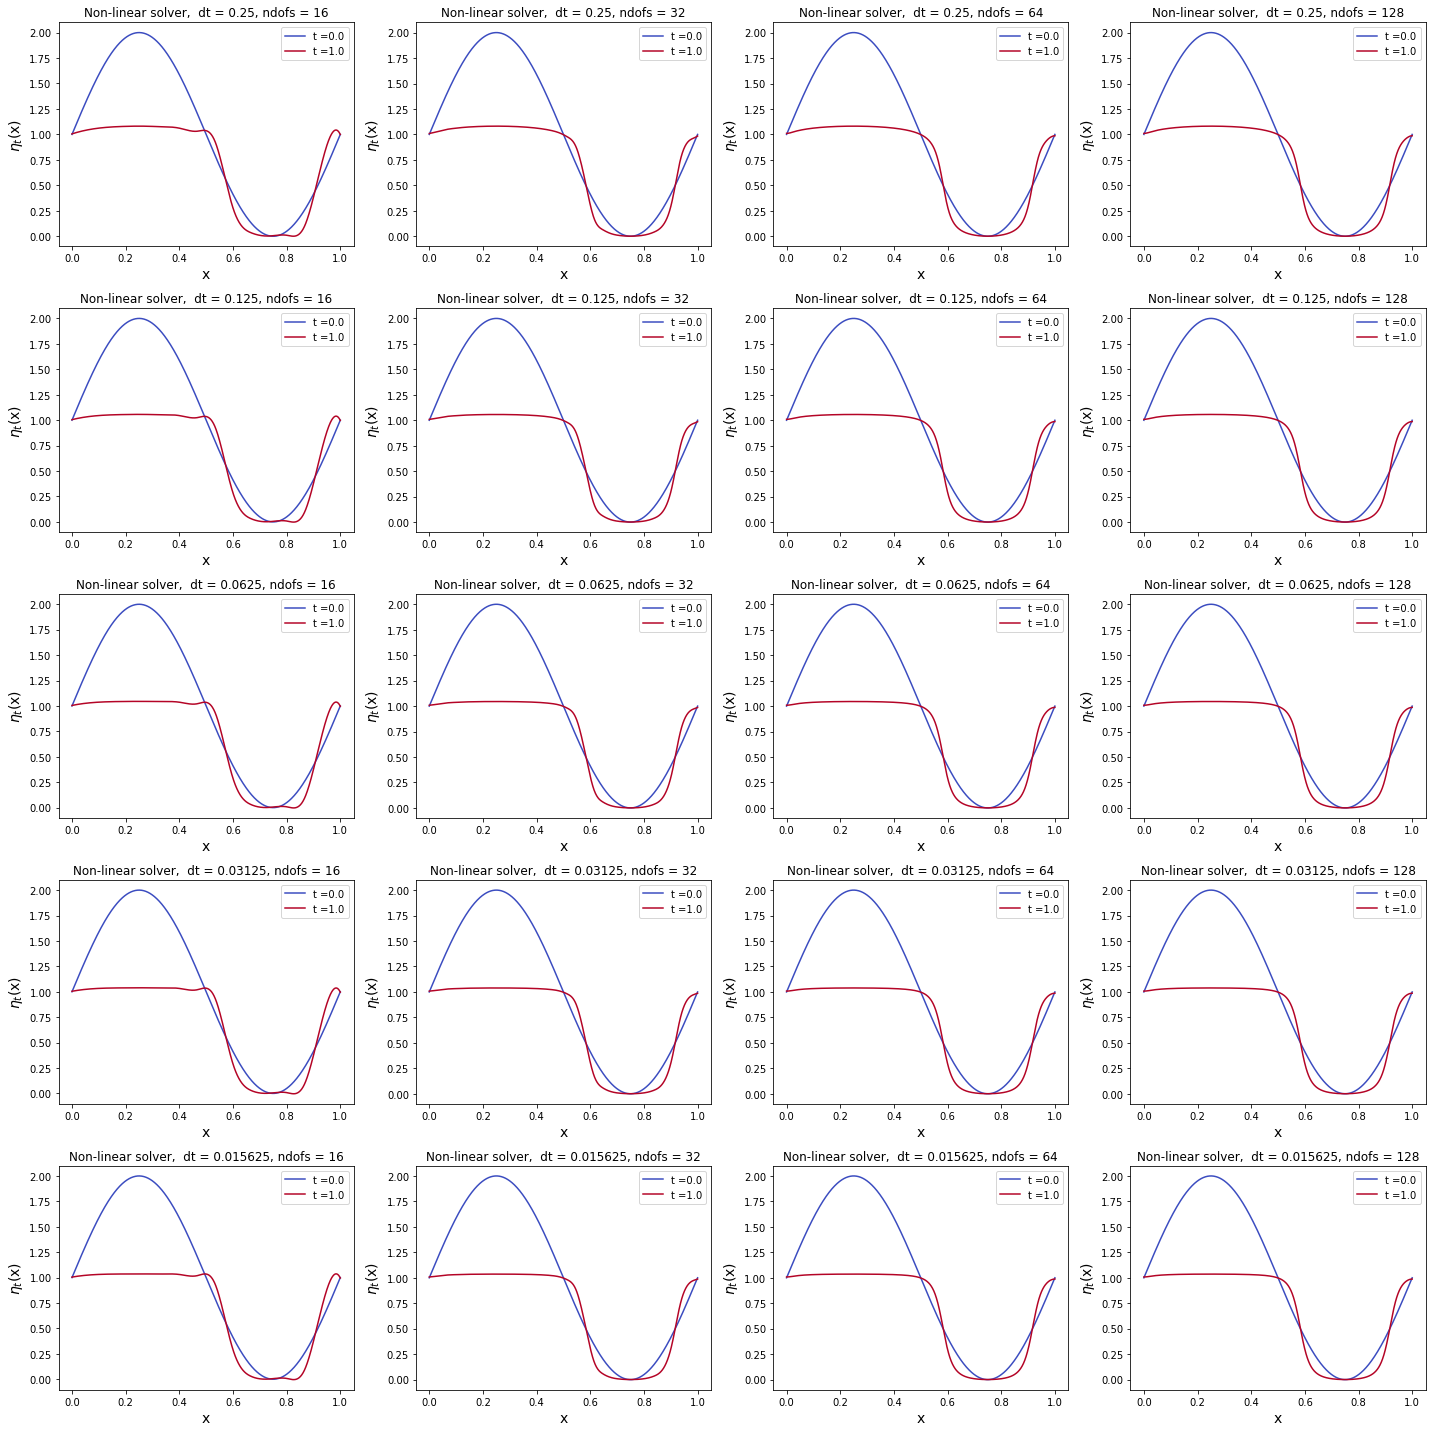

In [33]:
solutions(eps, degree, res, to_plot="non-linear")

#### Difference

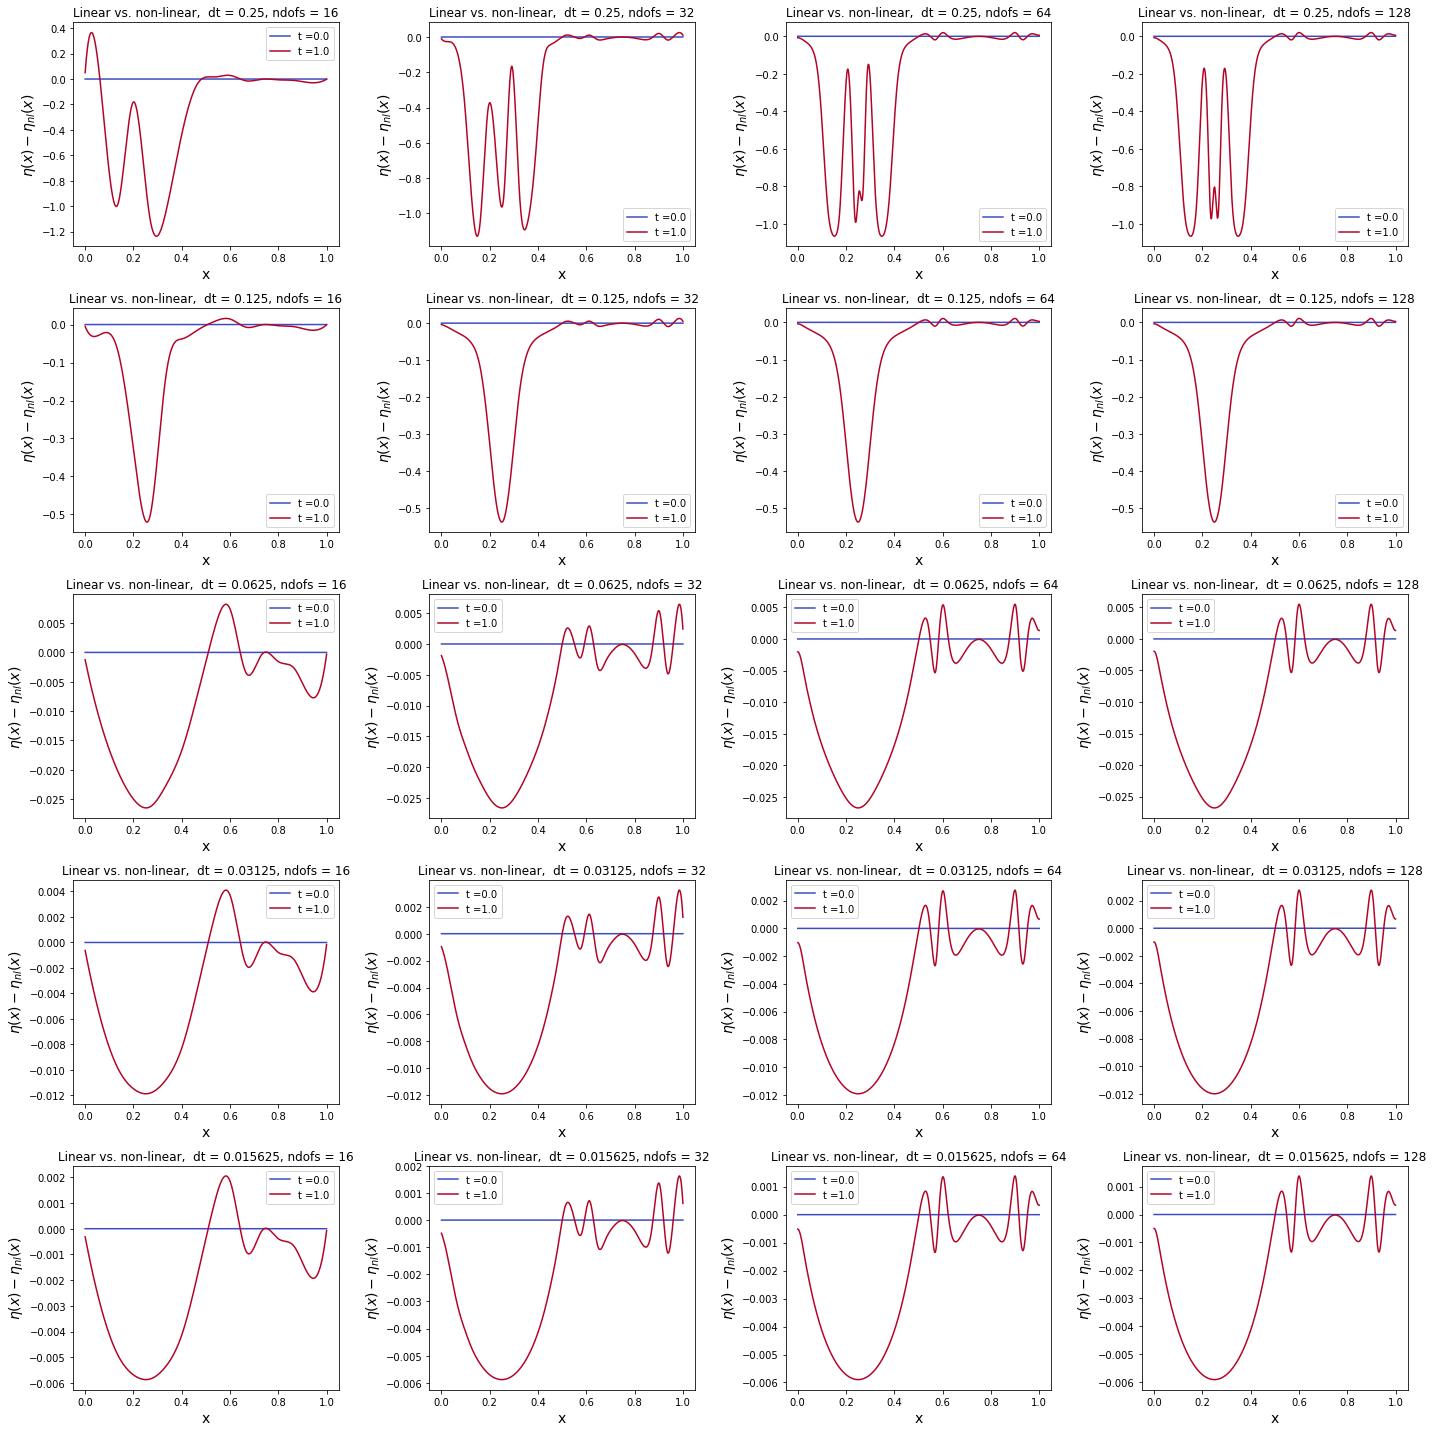

In [34]:
solutions(eps, degree, res, to_plot="difference")

### eps = 0.001, degree = 3

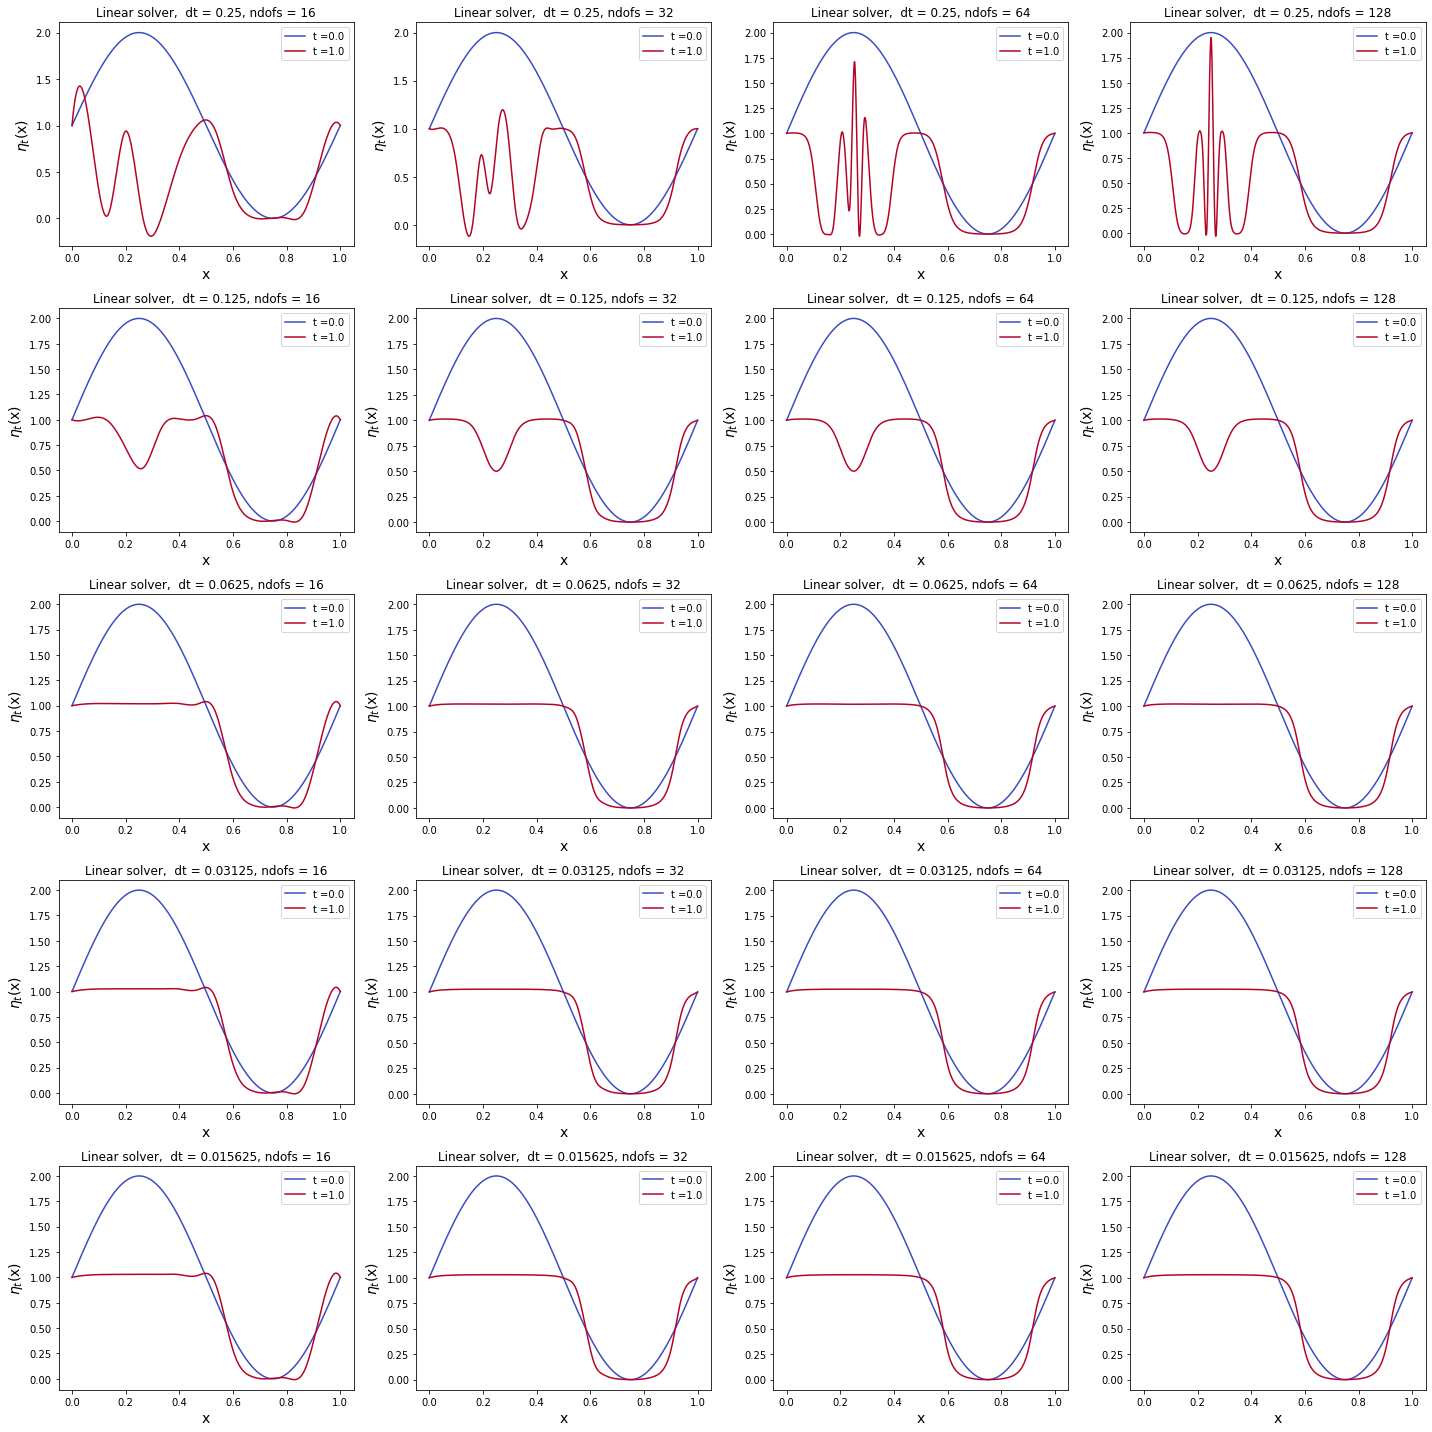

In [35]:
eps = 0.001
degree = 3
solutions(eps, degree, res, to_plot="linear")

#### Non-linear

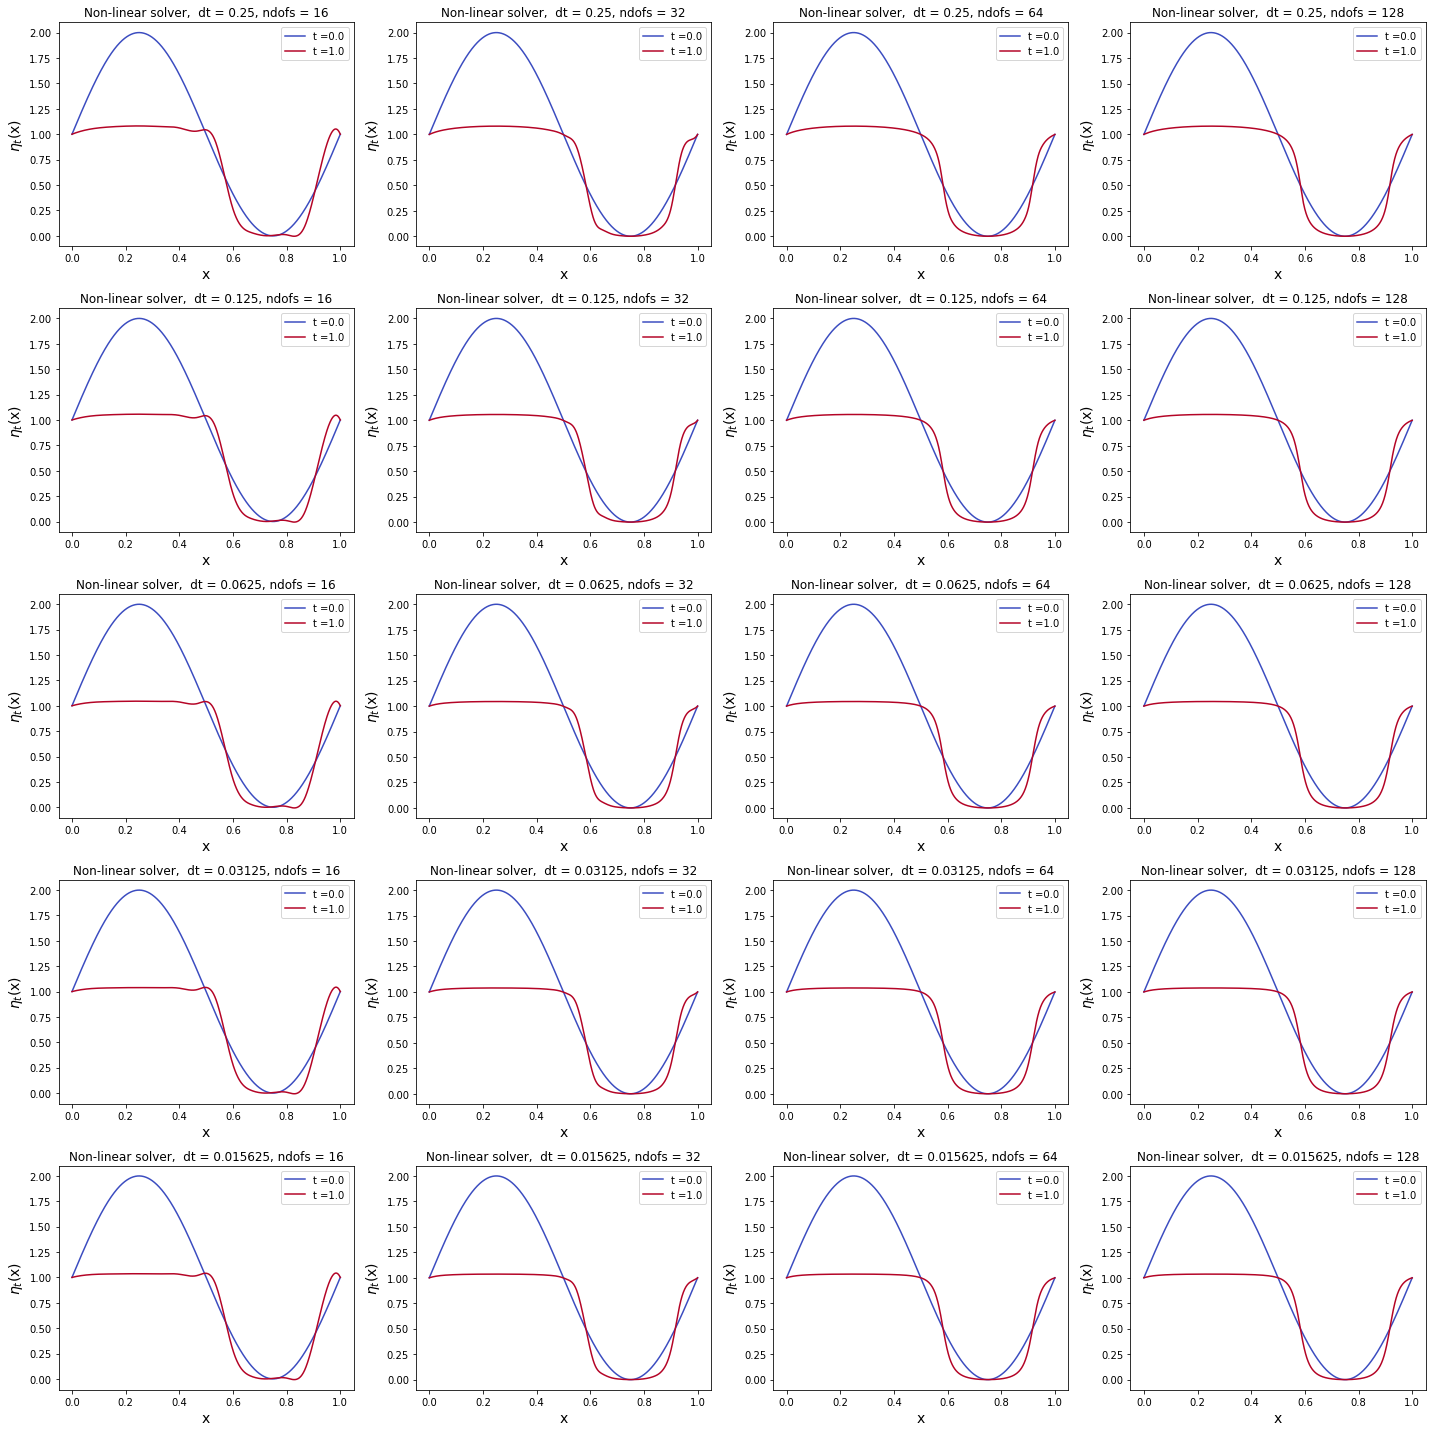

In [36]:
solutions(eps, degree, res, to_plot="non-linear")

#### Difference

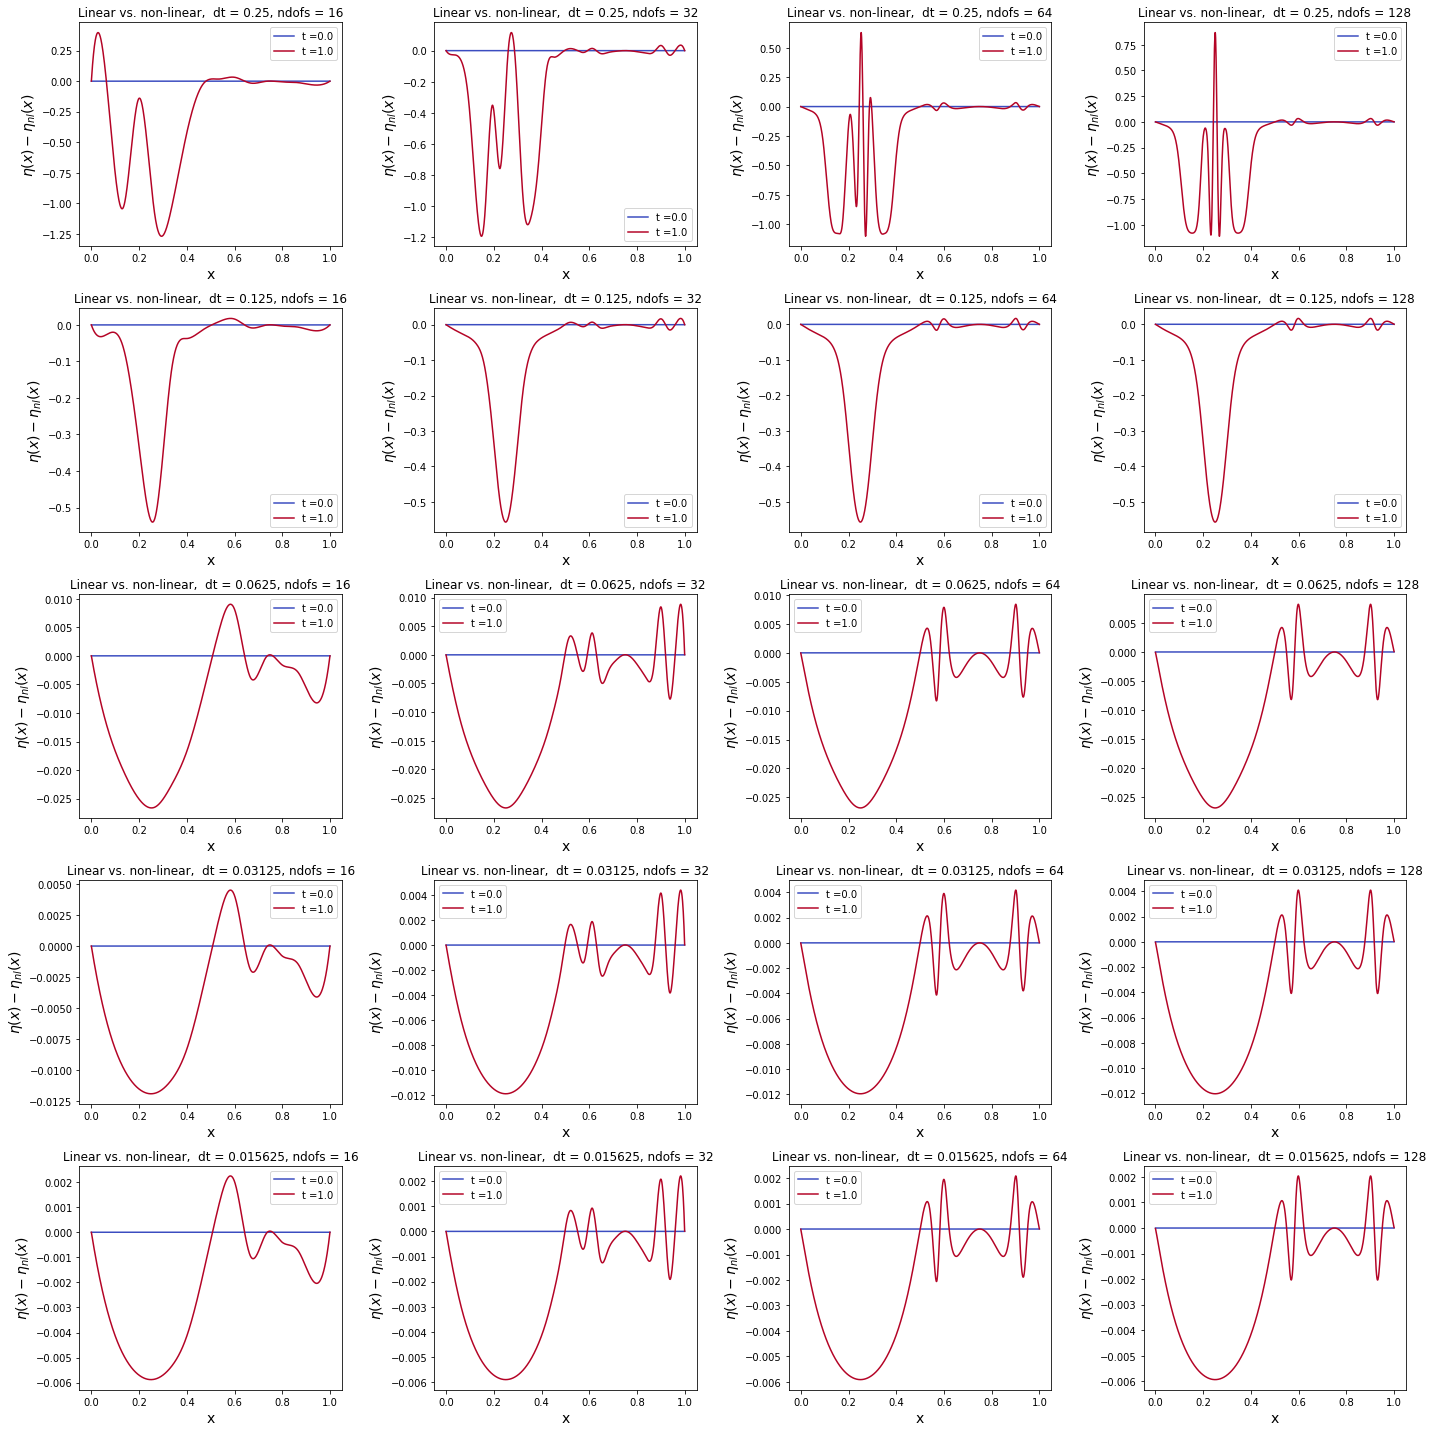

In [38]:
solutions(eps, degree, res, to_plot="difference")

### Final comments

- As expected, the plots of the final solution reflect the unconditional stability the non-linear solver. In the case of the fully implicit method convergence does not depend on the choice of $\Delta t$. Choosing a sufficiently high number of degrees of freedom (greater than 16) we have convergence for all degrees of interpolating splines. In the case of degree 1, larger number of degree of freedom implies smoother solutions.  
- In the case of the partially implicit method, the solution converges only for values of the time increment $\Delta t$ sufficiently small, i.e. $\Delta t < 0.0625$.
- Lower stifness coefficient ($\epsilon = 0.001$) implies higher instability of the partially implicit method for large values of $\Delta t$.
- For large values of $\Delta t$, considering higher degree of interpolating splines and/or larger number of degrees of freedom does not improve stability of the method. Solutions become smoother but not more accurate. 
- Once a sufficiently smal value of $\Delta t$ is chosen, we cannot observe significant differences among solutions with number of degree of freedom greater or equal than $32$ (or $64$ if the interpolating splines have degree $1$).